# Spotify Billboard Data Project

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
import os
import re
import ast

from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_text
from xgboost import XGBClassifier

path = kagglehub.dataset_download("yamaerenay/spotify-dataset-19212020-600k-tracks")

print("Path to dataset files:", path)
os.listdir(path)

Path to dataset files: C:\Users\woodj\.cache\kagglehub\datasets\yamaerenay\spotify-dataset-19212020-600k-tracks\versions\1


['artists.csv', 'dict_artists.json', 'tracks.csv']

## Data Importing and Cleaning

### Importing Data

In [5]:
# Billboard data

billboardPath = kagglehub.dataset_download("dhruvildave/billboard-the-hot-100-songs")

billboard = pd.read_csv(billboardPath + r"\charts.csv")  # file name from Kaggle dataset
billboard.head()

,date,rank,song,artist,last-week,peak-rank,weeks-on-board
0,2021-11-06,1,Easy On Me,Adele,1.0,1,3
1,2021-11-06,2,Stay,The Kid LAROI & Justin Bieber,2.0,1,16
2,2021-11-06,3,Industry Baby,Lil Nas X & Jack Harlow,3.0,1,14
3,2021-11-06,4,Fancy Like,Walker Hayes,4.0,3,19
4,2021-11-06,5,Bad Habits,Ed Sheeran,5.0,2,18


In [6]:
#Setting up dataframes

df_tracks = pd.read_csv(path + r"\tracks.csv")
df_artists = pd.read_csv(path + r"\artists.csv")

print(df_tracks.shape)
print(df_tracks.columns)

(586672, 20)
Index(['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')


### Cleaning Data

In [ ]:
# --- Clean out non-music / weird tracks ---
df_clean = df_tracks.copy()

# Safety: ensure 'year' exists
if "year" not in df_clean.columns:
    df_clean["year"] = pd.to_datetime(df_clean["release_date"], errors="coerce").dt.year

# Duration filter (20 minutes+ → drop)
MAX_DURATION_MS = 20 * 60 * 1000  # 20 minutes
mask_dur = df_clean["duration_ms"] >= MAX_DURATION_MS

# Keyword filter for obvious non-music / functional audio
keywords = [
    "sleep", "noise", "rain", "thunder", "meditation", "mantra", "chant",
    "lullaby", "asmr", "spa", "relax", "rainstorm", "ocean waves"
]
name_lower = df_clean["name"].str.lower().fillna("")
mask_kw = name_lower.str.contains("|".join(keywords))

# Acoustic filter for extreme noise/ambient drones
mask_feat = (
    (df_clean["instrumentalness"] > 0.95) &
    (df_clean["energy"] < 0.12) &
    (df_clean["danceability"] < 0.20)
)

# Combine all filters
mask_drop = mask_dur | mask_kw | mask_feat

print(f"Dropping {mask_drop.sum()} tracks out of {len(df_clean)} ({mask_drop.mean():.2%}) as non-music/functional audio.")

df_tracks_clean = df_clean.loc[~mask_drop].copy()

# Optional: replace the original so the rest of code doesn't change
df_tracks = df_tracks_clean


Dropping 7533 tracks out of 586672 (1.28%) as non-music/functional audio.


In [8]:
# data cleaning prep functions for matching with billboard:

import unicodedata

def strip_accents(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def clean_title(x):
    x = str(x).lower().strip()

    # Remove accents
    x = strip_accents(x)

    # Remove text after dash or colon
    x = x.split(' - ')[0]
    x = x.split(':')[0]

    # Remove parentheticals
    x = re.sub(r'\(.*?\)', '', x)

    # Remove feat.
    x = re.sub(r'feat\..*', '', x)

    # Remove version/remaster/live
    x = re.sub(r'remaster.*', '', x)
    x = re.sub(r'remasterizado.*', '', x)
    x = re.sub(r'live.*', '', x)
    x = re.sub(r'version.*', '', x)

    # Remove nonalphanumeric
    x = re.sub(r'[^a-z0-9 ]', '', x)

    # Collapse spaces
    x = re.sub(r'\s+', ' ', x)

    return x.strip()


def clean_artist(x):
    x = str(x).lower().strip()
    x = re.split(r'feat\.|,|&', x)[0]
    x = re.sub(r'[^a-z0-9 ]', '', x)
    x = re.sub(r'\s+', ' ', x)
    return x.strip()


In [9]:
billboard['title_clean']  = billboard['song'].apply(clean_title)
billboard['artist_clean'] = billboard['artist'].apply(clean_artist)

bb = billboard[['title_clean', 'artist_clean', 'peak-rank', 'weeks-on-board']].copy()
bb.rename(columns={'peak-rank': 'peak_rank', 'weeks-on-board': 'weeks_on_chart'}, inplace=True)

bb = (
    billboard
    .groupby(['title_clean', 'artist_clean'])
    .agg(
        peak_rank = ('peak-rank', 'min'),          # best rank ever
        weeks_on_chart = ('weeks-on-board', 'max') # maximum reported weeks
    )
    .reset_index()
)


In [10]:
def get_primary_artist(artists):
    # Handles list, stringified list, or comma-separated
    if isinstance(artists, list):
        return artists[0]

    s = str(artists)

    if s.startswith('[') and s.endswith(']'):
        try:
            parsed = ast.literal_eval(s)
            if isinstance(parsed, list) and len(parsed) > 0:
                return parsed[0]
        except:
            pass

    return re.split(r',|&', s)[0]

df_sp = df_tracks.copy()  

df_sp['primary_artist'] = df_sp['artists'].apply(get_primary_artist)
df_sp['title_clean']    = df_sp['name'].apply(clean_title)
df_sp['artist_clean']   = df_sp['primary_artist'].apply(clean_artist)


### Merging 

In [11]:
df_merged = df_sp.merge(
    bb,
    on=['title_clean', 'artist_clean'],
    how='left'
)

df_merged[['name', 'artists', 'peak_rank', 'weeks_on_chart']].head()



,name,artists,peak_rank,weeks_on_chart
0,Carve,['Uli'],NaN,NaN
1,Capítulo 2.16 - Banquero Anarquista,['Fernando Pessoa'],NaN,NaN
2,Vivo para Quererte - Remasterizado,['Ignacio Corsini'],NaN,NaN
3,El Prisionero - Remasterizado,['Ignacio Corsini'],NaN,NaN
4,Lady of the Evening,['Dick Haymes'],NaN,NaN


In [12]:
df_merged['peak_rank'].isna().mean()

np.float64(0.9567478619122525)

In [ ]:
# How many unique Billboard songs do we have after aggregation?
bb.shape[0], bb[['title_clean', 'artist_clean']].drop_duplicates().shape[0]


(29652, 29652)

In [ ]:

# How many rows in Spotify subset?
df_sp.shape


(579139, 24)

In [ ]:

# Match rate (just to double-check)
df_merged['peak_rank'].isna().mean(), 1 - df_merged['peak_rank'].isna().mean()

(np.float64(0.9567478619122525), np.float64(0.04325213808774753))

In [ ]:
# Example: thriller
df_merged[
    df_merged['name'].str.contains('thriller', case=False, na=False)
][['name', 'artists', 'peak_rank', 'weeks_on_chart']]

bb[
    bb['title_clean'].str.contains('thriller', case=False, na=False)
][['title_clean', 'artist_clean', 'peak_rank', 'weeks_on_chart']].head()


,title_clean,artist_clean,peak_rank,weeks_on_chart
25705,thriller,michael jackson,4,20
25706,thriller heads will roll,glee cast,38,2


In [17]:
from rapidfuzz import process, fuzz
import pandas as pd

# make sure bb has the expected columns
bb.head()

bb_groups = {
    artist: g.reset_index(drop=True)
    for artist, g in bb.groupby('artist_clean')
}
len(bb_groups)




9486

In [18]:

unmatched_mask = df_merged['peak_rank'].isna()
unmatched = df_merged[unmatched_mask].copy()
unmatched.shape

(554090, 26)

### Cleaning spotify so just one song listing for each song

In [19]:
def fuzzy_match_billboard(row, bb_groups, title_threshold=92):
    artist = row['artist_clean']
    title = row['title_clean']

    # No Billboard songs for this artist → no possible match
    if pd.isna(artist) or artist not in bb_groups:
        return pd.Series({
            'peak_rank_fuzzy': pd.NA,
            'weeks_on_chart_fuzzy': pd.NA,
            'fuzzy_score': pd.NA
        })

    cand = bb_groups[artist]  # DataFrame of songs for this artist
    titles = cand['title_clean'].tolist()

    # Use token_set_ratio to be robust to word order / extra tokens
    result = process.extractOne(
        title,
        titles,
        scorer=fuzz.token_set_ratio
    )

    if result is None:
        return pd.Series({
            'peak_rank_fuzzy': pd.NA,
            'weeks_on_chart_fuzzy': pd.NA,
            'fuzzy_score': pd.NA
        })

    best_title, score, idx = result

    # If similarity is too low, don't trust it
    if score < title_threshold:
        return pd.Series({
            'peak_rank_fuzzy': pd.NA,
            'weeks_on_chart_fuzzy': pd.NA,
            'fuzzy_score': score
        })

    matched_row = cand.iloc[idx]

    return pd.Series({
        'peak_rank_fuzzy': matched_row['peak_rank'],
        'weeks_on_chart_fuzzy': matched_row['weeks_on_chart'],
        'fuzzy_score': score
    })


In [ ]:
fuzzy_results = unmatched.apply(
    fuzzy_match_billboard,
    axis=1,
    bb_groups=bb_groups,
    title_threshold=92 
)

unmatched = pd.concat([unmatched, fuzzy_results], axis=1)
unmatched[['name', 'artists', 'peak_rank_fuzzy', 'weeks_on_chart_fuzzy', 'fuzzy_score']].head()


,name,artists,peak_rank_fuzzy,weeks_on_chart_fuzzy,fuzzy_score
0,Carve,['Uli'],<NA>,<NA>,<NA>
1,Capítulo 2.16 - Banquero Anarquista,['Fernando Pessoa'],<NA>,<NA>,<NA>
2,Vivo para Quererte - Remasterizado,['Ignacio Corsini'],<NA>,<NA>,<NA>
3,El Prisionero - Remasterizado,['Ignacio Corsini'],<NA>,<NA>,<NA>
4,Lady of the Evening,['Dick Haymes'],<NA>,<NA>,<NA>


In [21]:
unmatched.sort_values('fuzzy_score', ascending=False)[
    ['name', 'artists', 'title_clean', 'artist_clean', 'peak_rank_fuzzy', 'weeks_on_chart_fuzzy', 'fuzzy_score']
].head(20)


,name,artists,title_clean,artist_clean,peak_rank_fuzzy,weeks_on_chart_fuzzy,fuzzy_score
353335,Someone You Love - Remastered 2003,['Nat King Cole'],someone you love,nat king cole,81.0,4.0,100.0
277605,Flash's Theme - Remastered 2011,['Queen'],flashs theme,queen,42.0,10.0,100.0
112318,Coming Up on You - 2016 Remaster,['The Cars'],coming up on you,the cars,74.0,5.0,100.0
84659,"Work REMIX (feat. A$AP Rocky, French Montana, ...","['A$AP Ferg', 'A$AP Rocky', 'French Montana', ...",work remix,aap ferg,100.0,2.0,100.0
80679,The Hippy Hippy Shake - 2008 Remaster,['The Swinging Blue Jeans'],the hippy hippy shake,the swinging blue jeans,24.0,8.0,100.0
34587,Baby Won't You Please Come Home,['Sam Cooke'],baby wont you please come home,sam cooke,66.0,7.0,100.0
460602,Don't You,['Candlebox'],dont you,candlebox,78.0,18.0,100.0
48690,You,['Carpenters'],you,carpenters,35.0,10.0,100.0
476155,Time to Cry,['Paul Anka'],time to cry,paul anka,4.0,15.0,100.0
69485,Candle In The Wind 1997,['Elton John'],candle in the wind 1997,elton john,6.0,21.0,100.0


In [22]:
# rows where fuzzy found a match
use_fuzzy = unmatched['peak_rank_fuzzy'].notna()

# update in the big df
df_merged.loc[unmatched.index[use_fuzzy], 'peak_rank'] = unmatched.loc[use_fuzzy, 'peak_rank_fuzzy']
df_merged.loc[unmatched.index[use_fuzzy], 'weeks_on_chart'] = unmatched.loc[use_fuzzy, 'weeks_on_chart_fuzzy']

# track match type
if 'match_type' not in df_merged.columns:
    df_merged['match_type'] = 'none'

df_merged.loc[~unmatched_mask, 'match_type'] = 'exact'     # already matched originally
df_merged.loc[unmatched.index[use_fuzzy], 'match_type'] = 'fuzzy'

df_merged['match_type'].value_counts(dropna=False)


C:\Users\woodj\AppData\Local\Temp\ipykernel_15484\2675138082.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[100.0 44.0 47.0 ... 4.0 91.0 7.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_merged.loc[unmatched.index[use_fuzzy], 'peak_rank'] = unmatched.loc[use_fuzzy, 'peak_rank_fuzzy']
C:\Users\woodj\AppData\Local\Temp\ipykernel_15484\2675138082.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.0 10.0 7.0 ... 2.0 1.0 12.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_merged.loc[unmatched.index[use_fuzzy], 'weeks_on_chart'] = unmatched.loc[use_fuzzy, 'weeks_on_chart_fuzzy']


match_type
none     552772
exact     25049
fuzzy      1318
Name: count, dtype: int64

In [23]:
df_merged['peak_rank'].isna().mean(), 1 - df_merged['peak_rank'].isna().mean()

(np.float64(0.9544720697449144), np.float64(0.045527930255085614))

### Creating Target Variable

In [ ]:

df_merged['peak_rank'] = pd.to_numeric(df_merged['peak_rank'], errors='coerce')
df_merged['is_hit'] = df_merged['peak_rank'].notna().astype(int)

df_merged['is_hit'].value_counts()

is_hit
0    552772
1     26367
Name: count, dtype: int64

In [25]:

df_cleaned = (
    df_merged
    .sort_values(['is_hit', 'popularity'], ascending=[False, False])
    .groupby(['title_clean', 'artist_clean'])
    .head(1)
    .reset_index(drop=True)
)

## Making New Features

In [26]:
## making a feature for covers 
title_counts = df_cleaned['title_clean'].value_counts()


bb_title_to_artists = (
    bb.groupby('title_clean')['artist_clean']
      .apply(set)
      .to_dict()
)

def is_cover(row):
    title = row['title_clean']
    artist = row['artist_clean']

    # skip common titles ("Home", "Stay", etc.)
    if title_counts[title] > 2:
        return 0

    # only titles that WERE Billboard hits matter
    if title not in bb_title_to_artists:
        return 0

    # original artist → not a cover
    if artist in bb_title_to_artists[title]:
        return 0

    return 1   # a likely audio-similar cover/remake of a known hit



df_cleaned['is_cover'] = df_cleaned.apply(is_cover, axis=1)


### Merging in artists.csv for Genre data

In [27]:
# Merging the artists.csv dataset, so we can use genre as a feature:

#cleaning the artists again
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', str(s))
                   if unicodedata.category(c) != 'Mn')

def clean_artist(x):
    x = str(x).lower().strip()
    x = strip_accents(x)
    x = re.split(r"feat\.|,|&", x)[0]
    x = re.sub(r'[^a-z0-9 ]', '', x)
    x = re.sub(r'\s+', ' ', x)
    return x.strip()

df_artists['artist_clean'] = df_artists['name'].apply(clean_artist)


In [28]:
df_artists_small = df_artists[['artist_clean', 'popularity', 'followers', 'genres']].copy()
df_artists_small.rename(columns={
    'popularity': 'artist_popularity',
    'followers': 'artist_followers',
    'genres': 'artist_genres'
}, inplace=True)


In [29]:
#merge artists into the cleaned df

df_artists_small = df_artists_small.sort_values('artist_followers', ascending=False)
df_artists_small = df_artists_small.drop_duplicates(subset='artist_clean', keep='first')

df_enriched = df_cleaned.merge(
    df_artists_small,
    on='artist_clean',
    how='left'
)
df_enriched['artist_popularity'] = df_enriched['artist_popularity'].fillna(0)
df_enriched['artist_followers'] = df_enriched['artist_followers'].fillna(0)
df_enriched['artist_genres'] = df_enriched['artist_genres'].fillna("[]")




In [30]:
def parse_genre_list(g):
    try:
        if isinstance(g, list):
            return g
        return ast.literal_eval(str(g))
    except:
        return []
        
df_enriched['genre_list'] = df_enriched['artist_genres'].apply(parse_genre_list)


In [ ]:
MAIN_GENRES = [
    'pop', 'rock', 'hip hop', 'rap', 'r&b', 'soul',
    'electronic', 'edm', 'dance', 'latin', 'country',
    'jazz', 'blues', 'folk', 'metal'
]

for g in MAIN_GENRES:
    g_clean = g.replace(" ", "_")
    df_enriched[f'genre_{g_clean}'] = df_enriched['genre_list'].apply(
        lambda lst: int(any(g in genre.lower() for genre in lst))
    )

df_enriched['genres_text'] = df_enriched['genre_list'].apply(lambda g: " ".join(g))

#feature for number of genres
df_enriched['num_genres'] = df_enriched['genre_list'].apply(len)

# tracking if it leans towards a specific genre
#df_enriched['num_pop_subgenres'] = df_enriched['genre_list'].apply(
#    lambda lst: sum('pop' in g.lower() for g in lst)

### Engineering New Features

In [32]:
#audio interation features
df_enriched['energy_valence'] = df_enriched['energy'] * df_enriched['valence']
df_enriched['dance_energy']   = df_enriched['danceability'] * df_enriched['energy']
df_enriched['loudness_energy'] = df_enriched['loudness'] * df_enriched['energy']
df_enriched['speech_energy']   = df_enriched['speechiness'] * df_enriched['energy']

#audio contrast features 
df_enriched['energy_minus_valence'] = df_enriched['energy'] - df_enriched['valence']
df_enriched['dance_minus_acoustic'] = df_enriched['danceability'] - df_enriched['acousticness']
df_enriched['instrumental_minus_speech'] = df_enriched['instrumentalness'] - df_enriched['speechiness']

#transforming tempo and duration
df_enriched['log_tempo'] = np.log1p(df_enriched['tempo'])
df_enriched['log_duration'] = np.log1p(df_enriched['duration_ms'])

#creating buckets of tempos:

df_enriched['tempo'] = pd.to_numeric(df_enriched['tempo'], errors='coerce')

bins = [-np.inf, 80, 110, 140, np.inf]
labels = ['slow', 'mid', 'upbeat', 'fast']

df_enriched['tempo_bucket'] = pd.cut(
    df_enriched['tempo'],
    bins=bins,
    labels=labels
)

df_enriched['tempo_bucket'] = df_enriched['tempo_bucket'].astype('category')
df_enriched['tempo_bucket_code'] = df_enriched['tempo_bucket'].cat.codes


### Removing the super heavy colums not needed for model

In [ ]:
heavy_cols = [
    'genre_list', 'artist_genres', 'genres_text',
    'id_artists', 'artists', 'primary_artist',
    'id', 'match_type'  
]

df_model = df_enriched.drop(columns=heavy_cols, errors='ignore').copy()

# filter years
df_model = df_model[df_model['year'] >= 1960].reset_index(drop=True)

print(df_model.shape)
print(df_model.memory_usage(deep=True).sum() / 1e6, "MB")


(296490, 53)
204.283378 MB


In [34]:
#Creating followers buckets, not sure if ill used this
### wondering if this is too much of similarity to hits.


bucket_cols = ['followers_big', 'followers_medium', 'followers_small', 'followers_star', 'followers_tiny']
df_model = df_model.drop(columns=bucket_cols, errors='ignore')


def follower_bucket(x):
    if x < 1e4:   return 'tiny'
    elif x < 1e5: return 'small'
    elif x < 1e6: return 'medium'
    elif x < 1e7: return 'big'
    else:         return 'star'

df_model['artist_followers_log'] = np.log1p(df_model['artist_followers'].clip(lower=0))
df_model['followers_bucket'] = df_model['artist_followers'].apply(follower_bucket)

df_model = pd.get_dummies(
    df_model,
    columns=['followers_bucket'],
    prefix='followers'
)


print(df_model.columns[df_model.columns.duplicated()])


Index([], dtype='object')


### Slicing decades

In [35]:
#Creating decade slices

df_model['decade'] = (df_model['year'] // 10) * 10

decade_dfs = {
    1960: df_model[df_model['decade'] == 1960],

    1970: df_model[df_model['decade'] == 1970],

    1980: df_model[df_model['decade'] == 1980],

    1990: df_model[df_model['decade'] == 1990],
    
    2000: df_model[df_model['decade'] == 2000],

    2010: df_model[(df_model['decade'] == 2010)]

}

# Since the data goes back a long time, I think the model should be trained on just the more modern music, 2015+
## creating that df here:

df_modern = df_model[(df_model['year'] >= 2012) & (df_model['year'] <= 2021)]
df_modern_wide = df_model[(df_model['year'] >= 1980) & (df_model['year'] <= 2021)]
print(len(df_modern), "modern tracks after cleaning")
# Testing to remove the noise of the random bottom 

#df_modern = df_modern[df_modern['popularity'] >= 5]



79181 modern tracks after cleaning


In [36]:
print(df_model.columns)

Index(['name', 'popularity', 'duration_ms', 'explicit', 'release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'year', 'title_clean', 'artist_clean', 'peak_rank',
       'weeks_on_chart', 'is_hit', 'is_cover', 'artist_popularity',
       'artist_followers', 'genre_pop', 'genre_rock', 'genre_hip_hop',
       'genre_rap', 'genre_r&b', 'genre_soul', 'genre_electronic', 'genre_edm',
       'genre_dance', 'genre_latin', 'genre_country', 'genre_jazz',
       'genre_blues', 'genre_folk', 'genre_metal', 'num_genres',
       'energy_valence', 'dance_energy', 'loudness_energy', 'speech_energy',
       'energy_minus_valence', 'dance_minus_acoustic',
       'instrumental_minus_speech', 'log_tempo', 'log_duration',
       'tempo_bucket', 'tempo_bucket_code', 'artist_followers_log',
       'followers_big', 'followers_medium', 'followers_small',
       'followers_sta

### Deciding on final features

In [37]:
# Features

feature_cols = [
    'duration_ms', 'explicit',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'year',
        'is_cover',
        
        'genre_pop', 'genre_rock', 'genre_hip_hop',
       'genre_rap', 'genre_r&b', 'genre_soul', 'genre_electronic', 'genre_edm',
       'genre_dance', 'genre_latin', 'genre_country', 'genre_jazz',
       'genre_blues', 'genre_folk', 'genre_metal', 'num_genres',

       'energy_valence', 'dance_energy', 'loudness_energy', 'speech_energy',
       'energy_minus_valence', 'dance_minus_acoustic',
       'instrumental_minus_speech', 'log_tempo', 'log_duration',
       'tempo_bucket_code', 'decade',


]

fame_features = [
    'artist_popularity',
    'artist_followers_log',
    'followers_big',
    'followers_medium',
    'followers_small',
    'followers_star',
    'followers_tiny'
]

#target for popularity 

target = 'is_hit'

all_features = feature_cols + fame_features

## Modeling

In [38]:
X = df_modern[feature_cols] # with the fame features 
y = df_modern['is_hit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


### Logistic Regression

In [39]:
# Standardize the features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store all models and results

results = []
models = {}

logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)
models['Logistic Regression'] = logreg

### Decision Tree

In [40]:
print("2. Training Decision Tree ...")
simple_dt = DecisionTreeClassifier(class_weight='balanced' ,random_state=42)
simple_dt.fit(X_train, y_train)  # No scaling needed for Decision Trees
models['Decision Tree - Simple'] = simple_dt

2. Training Decision Tree ...


### Decision Tree w Gridsearch 

In [41]:
print("3. Training Decision Tree (Optimized with GridSearchCV)...")
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(dt, dt_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
models['Decision Tree - Optimized'] = best_dt

print(f"Best parameters for Decision Tree: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

3. Training Decision Tree (Optimized with GridSearchCV)...
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation score: 0.8331


### Random Forest

In [ ]:
print("4. Training Random Forest...")
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 6, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

best_rf = rf_grid_search.best_estimator_
models['Random Forest'] = best_rf
print(f"   Best RF params: {rf_grid_search.best_params_}")

4. Training Random Forest...
   Best RF params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


### XGBoost

In [43]:
print("Checking for duplicate columns...")
dupes = [c for c in X.columns if X.columns.tolist().count(c) > 1]
print("Duplicates:", dupes)

print("\nChecking for non-numeric dtypes:")
bad = X.dtypes[X.dtypes == "object"]
print(bad)

print("\nChecking for columns that return DataFrame instead of Series:")
bad_cols = []
for col in X.columns:
    out = X[col]
    if isinstance(out, pd.DataFrame):
        bad_cols.append(col)

print("Columns that return DataFrame:", bad_cols)


Checking for duplicate columns...
Duplicates: []

Checking for non-numeric dtypes:
Series([], dtype: object)

Checking for columns that return DataFrame instead of Series:
Columns that return DataFrame: []


In [44]:
print("5. Training XGBoost...")
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [ 5, 6, None],
    'learning_rate': [0.03, 0.1],
    'subsample': [0.8, 1.0]
}

pos = y_train.sum()
neg = len(y_train) - pos
scale = neg / pos

xgb = XGBClassifier(scale_pos_weight = scale, random_state=42, eval_metric='logloss')
xgb_grid_search = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='roc_auc', n_jobs=1)
xgb_grid_search.fit(X_train, y_train)

best_xgb = xgb_grid_search.best_estimator_
model_features = best_xgb.get_booster().feature_names
models['XGBoost'] = best_xgb
print(f"   Best XGB params: {xgb_grid_search.best_params_}")

5. Training XGBoost...
   Best XGB params: {'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


### XGBoost with all features

In [45]:
# 1) Build full feature matrix + target

X_full = df_modern[all_features]
y_full = df_modern['is_hit']

X_tr_full, X_te_full, y_tr_full, y_te_full = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

print("5. Training XGBoost (FULL FEATURES)...")

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 6, None],
    'learning_rate': [0.03, 0.1],
    'subsample': [0.8, 1.0]
}

# Class imbalance handling based on this full-feature train set
pos = y_tr_full.sum()
neg = len(y_tr_full) - pos
scale = neg / pos

xgb_full = XGBClassifier(
    scale_pos_weight=scale,
    random_state=42,
    eval_metric='logloss'
)

xgb_grid_full = GridSearchCV(
    xgb_full,
    xgb_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=1
)

xgb_grid_full.fit(X_tr_full, y_tr_full)

best_xgb_full = xgb_grid_full.best_estimator_
model_features_full = best_xgb_full.get_booster().feature_names

print(f"   Best XGB params (full): {xgb_grid_full.best_params_}")


# 3) Find best F1 threshold for THIS full model
probs_full = best_xgb_full.predict_proba(X_te_full)[:, 1]
prec, rec, thr = precision_recall_curve(y_te_full, probs_full)

f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_threshold_full = thr[best_idx]

print(f"Best F1 (full model): {f1[best_idx]:.3f} at threshold {best_threshold_full:.3f}")


5. Training XGBoost (FULL FEATURES)...
   Best XGB params (full): {'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best F1 (full model): 0.546 at threshold 0.871


## Model Evaluation

In [46]:
# Find the best threshold

from sklearn.metrics import precision_recall_curve

# Get probabilities

y_probs = best_xgb.predict_proba(X_test)[:, 1]

# Calculate P-R curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate F1 Score, handling division by zero safely
numerator = 2 * precision * recall
denominator = precision + recall
fscore = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)

# Find the index of the best F1 Score
ix = np.argmax(fscore)

best_threshold = float(thresholds[ix])

print('Best Threshold=%f, F1=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.817796, F1=0.380


In [ ]:
def evaluate_model(model, model_name, requires_scaling=False, threshold=0.5):
    """Evaluate a model and return comprehensive metrics"""

    # Select dataset
    if requires_scaling:
        X_eval = X_test_scaled
        X_train_eval = X_train_scaled
    else:
        X_eval = X_test
        X_train_eval = X_train

    # Probabilities only
    y_pred_proba = model.predict_proba(X_eval)[:, 1]
    y_train_proba = model.predict_proba(X_train_eval)[:, 1]

    # APPLY THE THRESHOLD
    y_pred = (y_pred_proba >= threshold).astype(int)
    y_train_pred = (y_train_proba >= threshold).astype(int)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_proba)

    return {
        'Model': model_name,
        'Threshold': threshold,
        'Test Accuracy': accuracy,
        'Test Precision': precision,
        'Test Recall': recall,
        'Test F1-Score': f1,
        'Test ROC-AUC': roc_auc,
        'Train Accuracy': train_accuracy,
        'Train ROC-AUC': train_roc_auc,
        'Accuracy Gap': train_accuracy - accuracy,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }


# Evaluate all models
model_results = []

for name, model in models.items():
    requires_scaling = (name == 'Logistic Regression')  # Only LR needs scaling

    if name.startswith("XGBoost"):
        thresh = best_threshold  
    else:
        thresh = 0.5

    result = evaluate_model(model, name, requires_scaling, threshold=thresh)
    model_results.append(result)

# Create consolidated results DataFrame
results_df = pd.DataFrame(model_results)
display(results_df.round(4))

,Model,Threshold,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Test ROC-AUC,Train Accuracy,Train ROC-AUC,Accuracy Gap,y_pred,y_pred_proba
0,Logistic Regression,0.5000,0.9739,0.4746,0.0681,0.1191,0.8575,0.9742,0.8586,0.0003,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.023774869387192792, 0.025371138636227697, 0..."
1,Decision Tree - Simple,0.5000,0.9595,0.2282,0.2360,0.2321,0.6074,1.0000,1.0000,0.0405,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Decision Tree - Optimized,0.5000,0.8014,0.0907,0.7372,0.1616,0.8511,0.8028,0.8608,0.0014,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.41413375570592487, 0.6330836410700921,..."
3,Random Forest,0.5000,0.8840,0.1366,0.6521,0.2259,0.8791,0.8948,0.9571,0.0108,"[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0.1174461543672267, 0.43297067248190496, 0.61..."
4,XGBoost,0.8178,0.9648,0.3504,0.4161,0.3804,0.9015,0.9694,0.9569,0.0045,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.041093078, 0.5000773, 0.71609896, 0.5999093..."


In [48]:
ranked_by_f1 = results_df.sort_values('Test F1-Score',ascending=False) 
print("\n📊 ALTERNATIVE RANKING BY F1-SCORE:")
print(ranked_by_f1[['Model', 'Test F1-Score', 'Test ROC-AUC']])

ranked_by_auc = results_df.sort_values('Test ROC-AUC',ascending=False)
print('')
print("🏆 MODEL RANKING BY ROC-AUC:")
print(ranked_by_auc[['Model', 'Test ROC-AUC', 'Test F1-Score']])


📊 ALTERNATIVE RANKING BY F1-SCORE:
                       Model  Test F1-Score  Test ROC-AUC
4                    XGBoost       0.380423      0.901531
1     Decision Tree - Simple       0.232057      0.607373
3              Random Forest       0.225874      0.879070
2  Decision Tree - Optimized       0.161557      0.851132
0        Logistic Regression       0.119149      0.857506

🏆 MODEL RANKING BY ROC-AUC:
                       Model  Test ROC-AUC  Test F1-Score
4                    XGBoost      0.901531       0.380423
3              Random Forest      0.879070       0.225874
0        Logistic Regression      0.857506       0.119149
2  Decision Tree - Optimized      0.851132       0.161557
1     Decision Tree - Simple      0.607373       0.232057


In [49]:
print("\n🔍 OVERFITTING ASSESSMENT:")

# Add overfitting level to results_df
results_df['Overfitting_Level'] = results_df['Accuracy Gap'].apply(
    lambda gap: "❌ SEVERE" if gap > 0.1 else 
               "⚠️ MODERATE" if gap > 0.05 else 
               "✅ MILD" if gap > 0.02 else "🎯 WELL_REGULARIZED"
)

# Print simplified table
print(results_df[['Model', 'Accuracy Gap', 'Overfitting_Level']].sort_values('Accuracy Gap', ascending=False))


🔍 OVERFITTING ASSESSMENT:
                       Model  Accuracy Gap   Overfitting_Level
1     Decision Tree - Simple      0.040538              ✅ MILD
3              Random Forest      0.010775  🎯 WELL_REGULARIZED
4                    XGBoost      0.004529  🎯 WELL_REGULARIZED
2  Decision Tree - Optimized      0.001377  🎯 WELL_REGULARIZED
0        Logistic Regression      0.000314  🎯 WELL_REGULARIZED


In [50]:
print("\n🎯 BUSINESS CONTEXT EVALUATION:")

# Scenario 1: High Precision Required
print("\n📧 FOR HIGH-PRECISION SCENARIOS (minimize false positives):")
high_precision = results_df.nlargest(3, 'Test Precision')[['Model', 'Test Precision', 'Test Recall']]
print(high_precision.to_string(index=False))

# Scenario 2: High Recall Required  
print("\n🏥 FOR HIGH-RECALL SCENARIOS (minimize false negatives):")
high_recall = results_df.nlargest(3, 'Test Recall')[['Model', 'Test Recall', 'Test Precision']]
print(high_recall.to_string(index=False))

# Scenario 3: Balanced Approach
print("\n⚖️ FOR BALANCED PERFORMANCE (optimize F1-score):")
balanced = results_df.nlargest(3, 'Test F1-Score')[['Model', 'Test F1-Score', 'Test ROC-AUC']]
print(balanced.to_string(index=False))


🎯 BUSINESS CONTEXT EVALUATION:

📧 FOR HIGH-PRECISION SCENARIOS (minimize false positives):
                 Model  Test Precision  Test Recall
   Logistic Regression        0.474576     0.068127
               XGBoost        0.350410     0.416058
Decision Tree - Simple        0.228235     0.236010

🏥 FOR HIGH-RECALL SCENARIOS (minimize false negatives):
                    Model  Test Recall  Test Precision
Decision Tree - Optimized     0.737226        0.090719
            Random Forest     0.652068        0.136595
                  XGBoost     0.416058        0.350410

⚖️ FOR BALANCED PERFORMANCE (optimize F1-score):
                 Model  Test F1-Score  Test ROC-AUC
               XGBoost       0.380423      0.901531
Decision Tree - Simple       0.232057      0.607373
         Random Forest       0.225874      0.879070


### ROC Curves

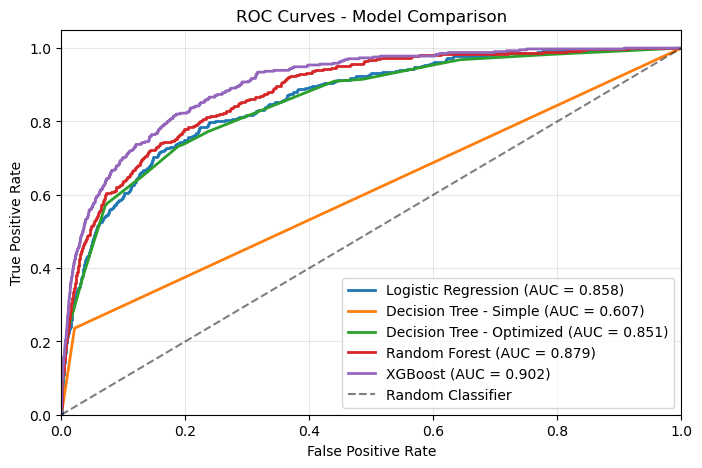

In [51]:
plt.figure(figsize=(8, 5))
for result in model_results:
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    auc_score = roc_auc_score(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{result['Model']} (AUC = {auc_score:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Confusion matrices

In [52]:
for result in model_results:
    cm = confusion_matrix(y_test, result['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n📋 {result['Model']}:")
    print(f"   True Negatives: {tn:3d} | False Positives: {fp:3d}")
    print(f"   False Negatives: {fn:3d} | True Positives: {tp:3d}")
    print(f"   → Accuracy: {result['Test Accuracy']:.4f}")
    print(f"   → Precision: {result['Test Precision']:.4f}")
    print(f"   → Recall: {result['Test Recall']:.4f}")


📋 Logistic Regression:
   True Negatives: 15395 | False Positives:  31
   False Negatives: 383 | True Positives:  28
   → Accuracy: 0.9739
   → Precision: 0.4746
   → Recall: 0.0681

📋 Decision Tree - Simple:
   True Negatives: 15098 | False Positives: 328
   False Negatives: 314 | True Positives:  97
   → Accuracy: 0.9595
   → Precision: 0.2282
   → Recall: 0.2360

📋 Decision Tree - Optimized:
   True Negatives: 12389 | False Positives: 3037
   False Negatives: 108 | True Positives: 303
   → Accuracy: 0.8014
   → Precision: 0.0907
   → Recall: 0.7372

📋 Random Forest:
   True Negatives: 13732 | False Positives: 1694
   False Negatives: 143 | True Positives: 268
   → Accuracy: 0.8840
   → Precision: 0.1366
   → Recall: 0.6521

📋 XGBoost:
   True Negatives: 15109 | False Positives: 317
   False Negatives: 240 | True Positives: 171
   → Accuracy: 0.9648
   → Precision: 0.3504
   → Recall: 0.4161


## Feature Importances

In [53]:
tree_based_models = {
    'Decision Tree (Optimized)': models['Decision Tree - Optimized'],
    'Random Forest': models['Random Forest'],
    'XGBoost': models['XGBoost']
}

for name, model in tree_based_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train.columns
        
        # Get feature importance sorted in descending order
        indices = np.argsort(importances)[::-1]
        sorted_importances = importances[indices]
        sorted_features = [feature_names[i] for i in indices]
        
        print(f"\n🌳 {name}:")
        print("-" * 50)
        
        # Print top 10 features
        for i in range(min(10, len(sorted_features))):
            print(f"   {i+1:2d}. {sorted_features[i]:20s} : {sorted_importances[i]:.4f}")
        
        # Calculate concentration of importance
        top5_importance = sum(sorted_importances[:5])
        print(f"   💡 Top 5 features account for {top5_importance:.1%} of total importance")


🌳 Decision Tree (Optimized):
--------------------------------------------------
    1. num_genres           : 0.3822
    2. genre_country        : 0.1631
    3. genre_dance          : 0.0831
    4. explicit             : 0.0826
    5. genre_rap            : 0.0582
    6. genre_hip_hop        : 0.0451
    7. instrumental_minus_speech : 0.0344
    8. acousticness         : 0.0261
    9. genre_pop            : 0.0227
   10. log_tempo            : 0.0152
   💡 Top 5 features account for 76.9% of total importance

🌳 Random Forest:
--------------------------------------------------
    1. num_genres           : 0.1767
    2. genre_country        : 0.1074
    3. genre_rap            : 0.0559
    4. genre_dance          : 0.0535
    5. explicit             : 0.0459
    6. loudness_energy      : 0.0443
    7. instrumentalness     : 0.0382
    8. instrumental_minus_speech : 0.0377
    9. acousticness         : 0.0313
   10. genre_pop            : 0.0285
   💡 Top 5 features account for 43.9% of t

In [54]:
# Identify best model based on comprehensive criteria
best_overall = ranked_by_auc.iloc[0]
best_balanced = results_df.loc[results_df['Test F1-Score'].idxmax()]
best_generalized = results_df.loc[results_df['Accuracy Gap'].idxmin()]

print(f"🏆 BEST OVERALL PERFORMER: {best_overall['Model']}")
print(f"   → ROC-AUC: {best_overall['Test ROC-AUC']:.4f}, F1-Score: {best_overall['Test F1-Score']:.4f}")

print(f"⚖️  BEST BALANCED PERFORMER: {best_balanced['Model']}")
print(f"   → F1-Score: {best_balanced['Test F1-Score']:.4f}, ROC-AUC: {best_balanced['Test ROC-AUC']:.4f}")

print(f"🎯 BEST GENERALIZED MODEL: {best_generalized['Model']}")
print(f"   → Overfitting Gap: {best_generalized['Accuracy Gap']:.4f}")

print("\n💡 RECOMMENDATION:")
if best_overall['Model'] == best_generalized['Model']:
    print("   ✅ Strong recommendation for production deployment")
else:
    print("   🤔 Consider trade-off between performance and generalization")

🏆 BEST OVERALL PERFORMER: XGBoost
   → ROC-AUC: 0.9015, F1-Score: 0.3804
⚖️  BEST BALANCED PERFORMER: XGBoost
   → F1-Score: 0.3804, ROC-AUC: 0.9015
🎯 BEST GENERALIZED MODEL: Logistic Regression
   → Overfitting Gap: 0.0003

💡 RECOMMENDATION:
   🤔 Consider trade-off between performance and generalization


### SHAP

In [55]:
import shap

In [56]:
xgb = best_xgb

builtin_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,              # same features used to train xgb
    'builtin_importance': xgb.feature_importances_
})

In [ ]:
# =============================================================================
# SHAP ANALYSIS - GLOBAL IMPORTANCE
# =============================================================================
print("\n" + "="*60)
print("6. SHAP ANALYSIS - GLOBAL IMPORTANCE")
print("="*60)

# XGBoost SHAP Analysis
print("\n--- XGBoost SHAP Analysis ---")
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Calculate SHAP importance
shap_importance_xgb = pd.DataFrame({
    'feature': X_test.columns,
    'shap_importance': np.abs(shap_values_xgb).mean(0)
}).sort_values('shap_importance', ascending=False)

print("Top 10 features by SHAP importance:")
print(shap_importance_xgb.head(10).round(4))

# Compare with built-in feature importance
print("\nComparison with XGBoost built-in importance:")
importance_comparison_xgb = pd.merge(
    builtin_importance_xgb,
    shap_importance_xgb,
    on='feature',
    suffixes=('_builtin', '_shap')
) .sort_values('shap_importance', ascending=False) .head(10)
print(importance_comparison_xgb.round(4))


6. SHAP ANALYSIS - GLOBAL IMPORTANCE

--- XGBoost SHAP Analysis ---
Top 10 features by SHAP importance:
             feature  shap_importance
31        num_genres           0.8521
18     genre_hip_hop           0.2786
1           explicit           0.2422
34   loudness_energy           0.1892
19         genre_rap           0.1790
8       acousticness           0.1704
26     genre_country           0.1694
9   instrumentalness           0.1498
16         genre_pop           0.1373
0        duration_ms           0.1263

Comparison with XGBoost built-in importance:
             feature  builtin_importance  shap_importance
31        num_genres              0.0939           0.8521
18     genre_hip_hop              0.0539           0.2786
1           explicit              0.0698           0.2422
34   loudness_energy              0.0258           0.1892
19         genre_rap              0.0438           0.1790
8       acousticness              0.0209           0.1704
26     genre_country     


7. SHAP DEPENDENCE PLOTS

--- XGBoost Dependence Plots ---
Top 3 XGBoost features: ['num_genres', 'genre_hip_hop', 'explicit']


<Figure size 1000x600 with 0 Axes>

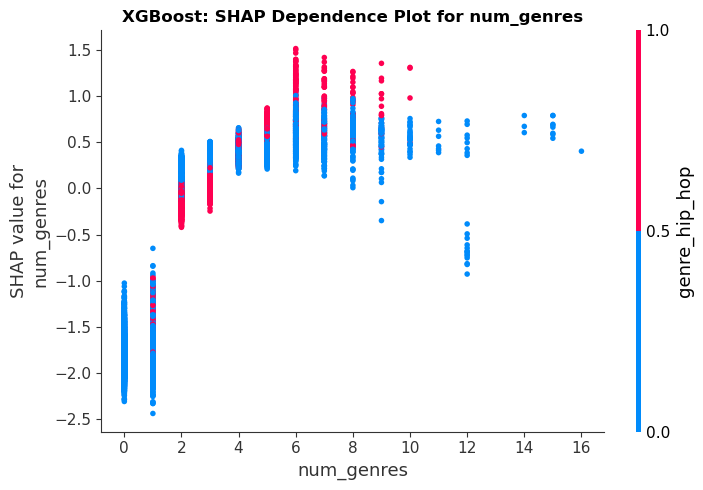

<Figure size 1000x600 with 0 Axes>

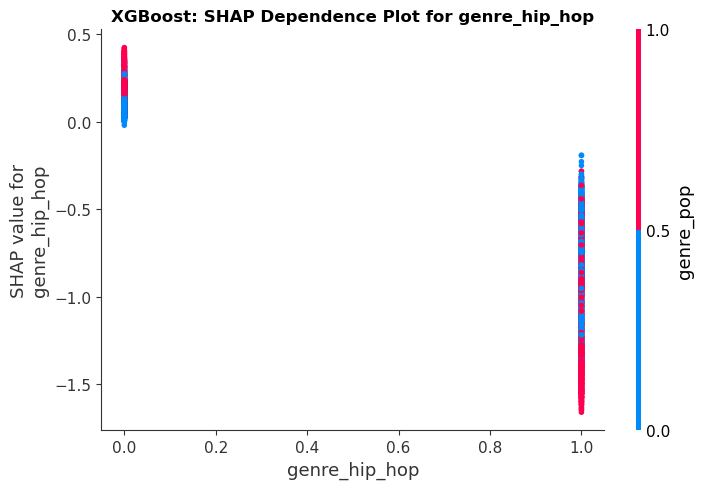

<Figure size 1000x600 with 0 Axes>

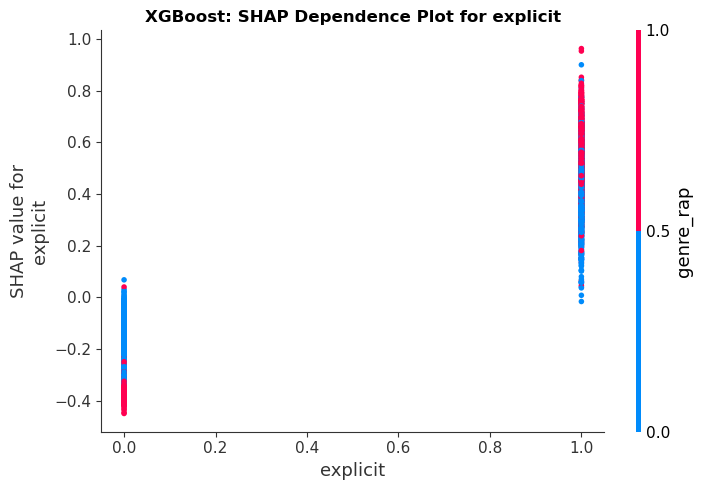

In [ ]:
# =============================================================================
#  SHAP DEPENDENCE PLOTS
# =============================================================================
print("\n" + "="*60)
print("7. SHAP DEPENDENCE PLOTS")
print("="*60)

# XGBoost Dependence Plots
print("\n--- XGBoost Dependence Plots ---")
top_xgb_features = shap_importance_xgb.head(3)['feature'].tolist()
print(f"Top 3 XGBoost features: {top_xgb_features}")

for feature in top_xgb_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values_xgb, X_test, show=False)
    plt.title(f"XGBoost: SHAP Dependence Plot for {feature}", fontweight='bold')
    plt.tight_layout()
    plt.show()

### Beeswarm


9. BEESWARM PLOTS - TOP 10 FEATURES

--- XGBoost Beeswarm Plot (Top 10 Features) ---


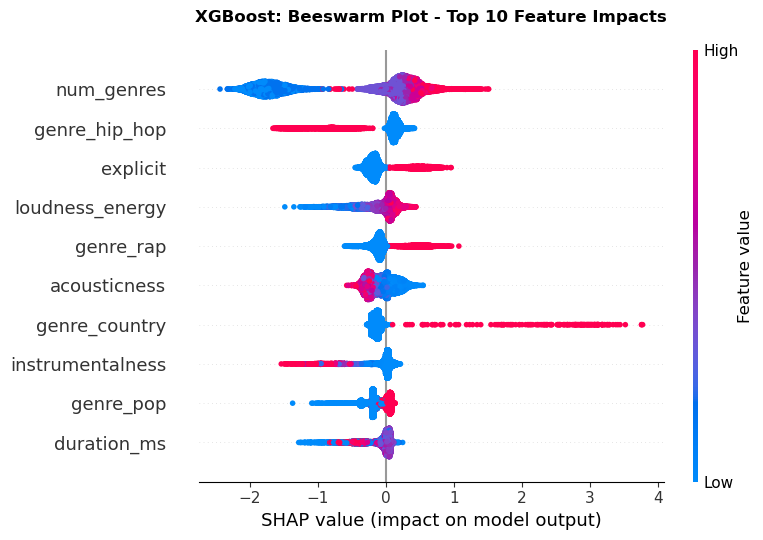

In [ ]:
#  BEESWARM PLOTS - TOP 10 FEATURES
# =============================================================================
print("\n" + "="*60)
print("9. BEESWARM PLOTS - TOP 10 FEATURES")
print("="*60)

# XGBoost Beeswarm Plot - Top 10 Features
print("\n--- XGBoost Beeswarm Plot (Top 10 Features) ---")

# Get top 10 features for XGBoost
top_10_xgb_indices = np.argsort(np.abs(shap_values_xgb).mean(0))[-10:][::-1]
top_10_xgb_shap = shap_values_xgb[:, top_10_xgb_indices]
top_10_xgb_features = [X_test.columns[i] for i in top_10_xgb_indices]
top_10_xgb_data = X_test.iloc[:, top_10_xgb_indices]

plt.figure(figsize=(12, 8))
shap.summary_plot(top_10_xgb_shap, top_10_xgb_data,
                  feature_names=top_10_xgb_features, show=False)
plt.title("XGBoost: Beeswarm Plot - Top 10 Feature Impacts", fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Local SHAP


8. LOCAL EXPLANATIONS - INDIVIDUAL PREDICTIONS

--- XGBoost Local Explanations ---

--- Most Confident Predicted Hit (Index 1915) ---
Song:   beat of the music
Artist: brett eldredge
Year:   2013.0
Actual label (is_hit): 1
Predicted label:       1
Predicted P(hit):      0.978
Prediction error:      -0.022


<Figure size 1200x400 with 0 Axes>

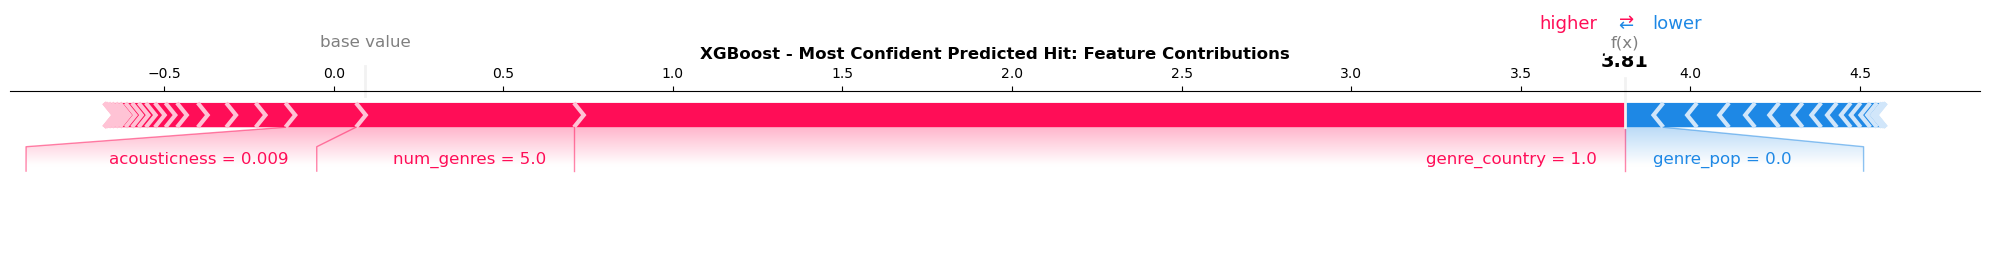

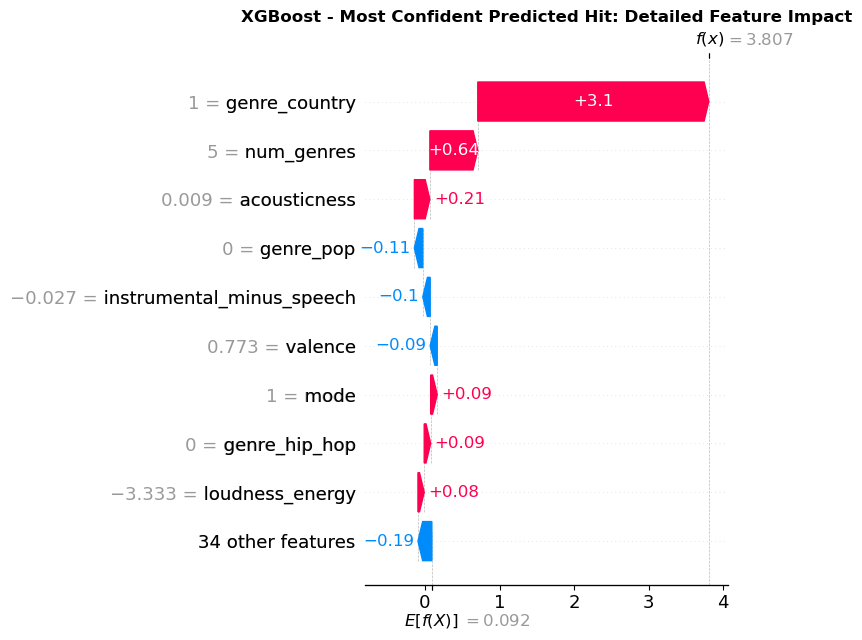


--- Most Confident Predicted Non-Hit (Index 8724) ---
Song:   bigfoot
Artist: w
Year:   2014.0
Actual label (is_hit): 0
Predicted label:       0
Predicted P(hit):      0.002
Prediction error:      0.002


<Figure size 1200x400 with 0 Axes>

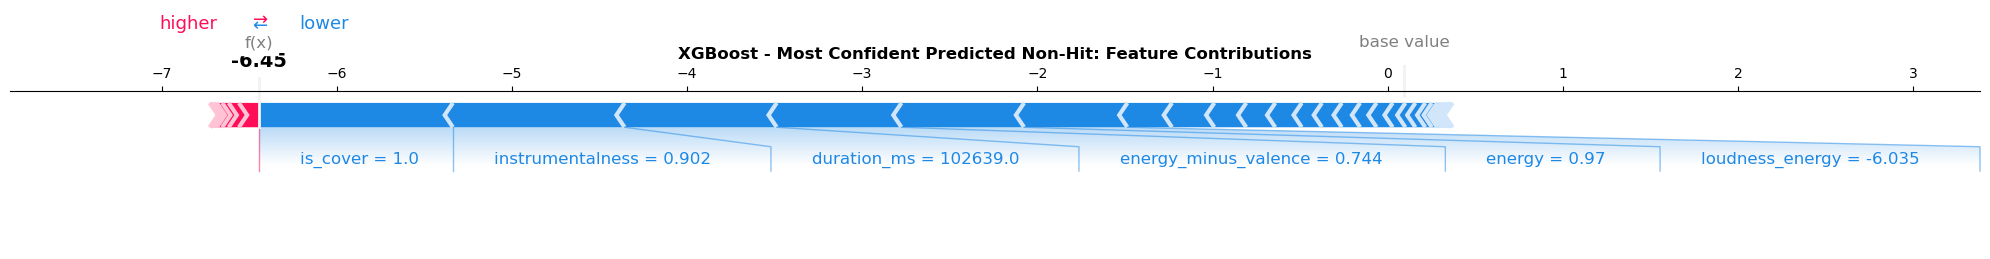

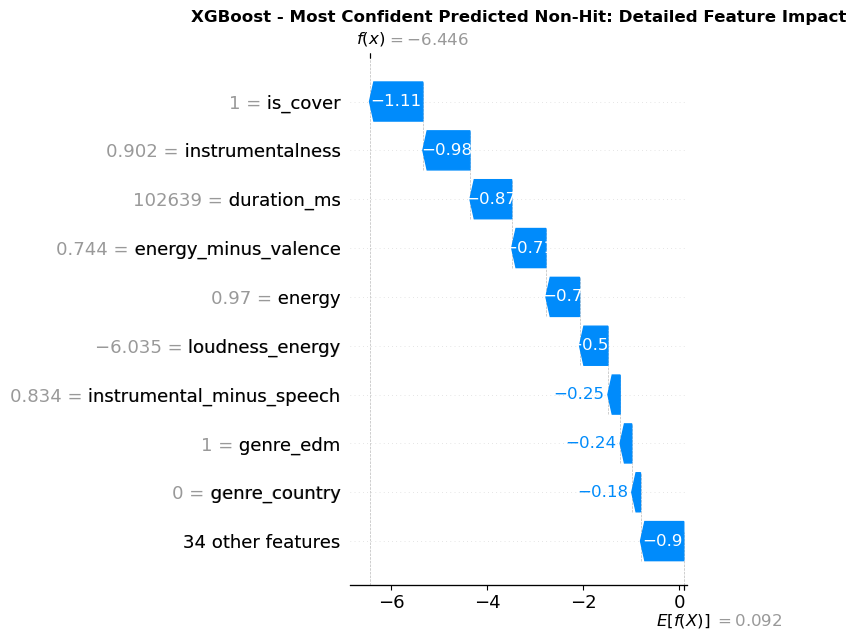


--- Largest Prediction Error (Index 14377) ---
Song:   animals
Artist: martin garrix
Year:   2013.0
Actual label (is_hit): 1
Predicted label:       0
Predicted P(hit):      0.020
Prediction error:      -0.980


<Figure size 1200x400 with 0 Axes>

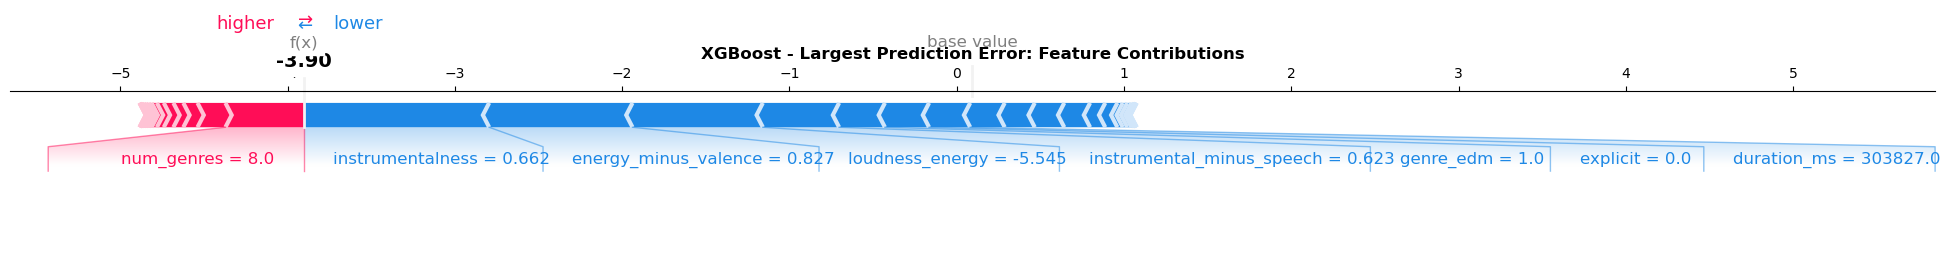

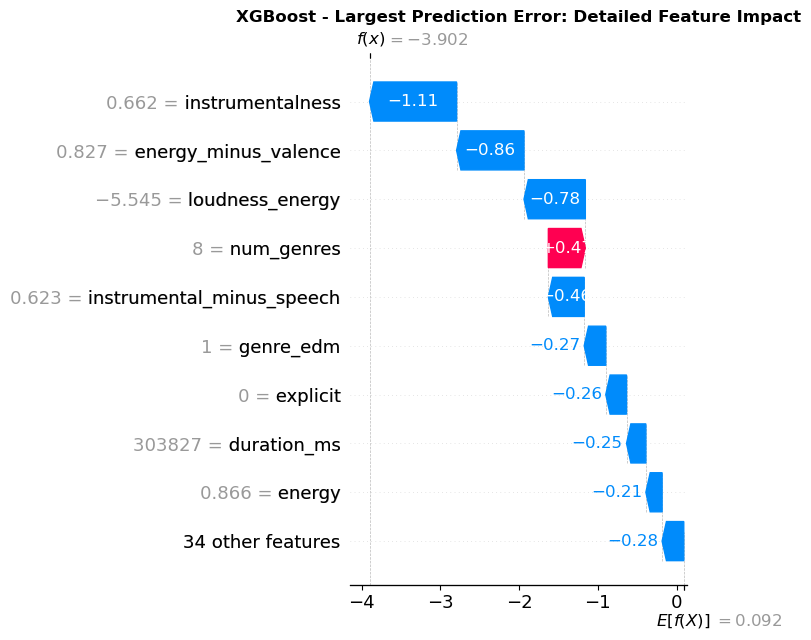

In [ ]:
print("\n" + "="*60)
print(" LOCAL EXPLANATIONS - INDIVIDUAL PREDICTIONS")
print("="*60)

# Predicted probabilities for the "hit" class
probs = xgb.predict_proba(X_test)[:, 1]
y_pred = xgb.predict(X_test)

# Choose interesting samples
sample_indices = [
    np.argmax(probs),                               # highest predicted hit probability
    np.argmin(probs),                               # lowest predicted hit probability
    np.argmax(np.abs(y_test.values - probs)),       # largest absolute error
]

sample_descriptions = [
    "Most Confident Predicted Hit",
    "Most Confident Predicted Non-Hit",
    "Largest Prediction Error",
]

print("\n--- XGBoost Local Explanations ---")
for idx, desc in zip(sample_indices, sample_descriptions):
    print(f"\n--- {desc} (Index {idx}) ---")

    actual = y_test.iloc[idx]
    prob_hit = probs[idx]
    pred_label = y_pred[idx]

    #PRINT EXAMPLE
    original_idx = X_test.index[idx]
    row = df_model.loc[original_idx]

    print(f"Song:   {row['title_clean']}")
    print(f"Artist: {row['artist_clean']}")
    print(f"Year:   {row['year']}")


    print(f"Actual label (is_hit): {actual}")
    print(f"Predicted label:       {pred_label}")
    print(f"Predicted P(hit):      {prob_hit:.3f}")
    print(f"Prediction error:      {prob_hit - actual:.3f}")

    sample_data = X_test.iloc[idx:idx+1].copy()
    sample_data_rounded = sample_data.round(3)

    # Force plot
    plt.figure(figsize=(12, 4))
    shap.force_plot(
        explainer_xgb.expected_value,
        shap_values_xgb[idx:idx+1, :],
        sample_data_rounded,
        matplotlib=True,
        show=False
    )
    plt.title(f"XGBoost - {desc}: Feature Contributions", fontweight="bold")
    plt.tight_layout()
    plt.show()

    # Waterfall plot
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_xgb[idx, :],
            base_values=explainer_xgb.expected_value,
            data=sample_data_rounded.iloc[0].values,
            feature_names=X_test.columns.tolist()
        ),
        show=False
    )
    plt.title(f"XGBoost - {desc}: Detailed Feature Impact", fontweight="bold")
    plt.tight_layout()
    plt.show()


## Should have been a hit? Unlikley Hits?

In [ ]:

target_model_name = "XGBoost" 

eval_dict = next(r for r in model_results if r["Model"] == target_model_name)

# Get predictions and probabilities
y_pred_default = eval_dict["y_pred"]
y_prob = eval_dict["y_pred_proba"]

y_pred = y_pred_default

# best_threshold = 0.845345
# y_pred = (y_prob >= best_threshold).astype(int)

# Build test results DataFrame
df_test_results = df_model.loc[X_test.index].copy()

df_test_results["y_true"] = y_test.values
df_test_results["y_prob"] = y_prob
df_test_results["y_pred"] = y_pred

# Tag FPs and FNs
df_test_results["error_type"] = None
df_test_results.loc[(df_test_results.y_true == 0) & (df_test_results.y_pred == 1), "error_type"] = "FP"
df_test_results.loc[(df_test_results.y_true == 1) & (df_test_results.y_pred == 0), "error_type"] = "FN"



In [64]:
print(df_test_results.columns.tolist())

['name', 'popularity', 'duration_ms', 'explicit', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'year', 'title_clean', 'artist_clean', 'peak_rank', 'weeks_on_chart', 'is_hit', 'is_cover', 'artist_popularity', 'artist_followers', 'genre_pop', 'genre_rock', 'genre_hip_hop', 'genre_rap', 'genre_r&b', 'genre_soul', 'genre_electronic', 'genre_edm', 'genre_dance', 'genre_latin', 'genre_country', 'genre_jazz', 'genre_blues', 'genre_folk', 'genre_metal', 'num_genres', 'energy_valence', 'dance_energy', 'loudness_energy', 'speech_energy', 'energy_minus_valence', 'dance_minus_acoustic', 'instrumental_minus_speech', 'log_tempo', 'log_duration', 'tempo_bucket', 'tempo_bucket_code', 'artist_followers_log', 'followers_big', 'followers_medium', 'followers_small', 'followers_star', 'followers_tiny', 'decade', 'y_true', 'y_prob', 'y_pred', 'error_type']


In [65]:
#FP

df_fp = df_test_results[
    (df_test_results["error_type"] == "FP") &
    (df_test_results["year"] >= 1960)
].copy()

df_fp = df_fp.sort_values("y_prob", ascending=False)
df_fp.head(20)[["name", "artist_clean","year", "y_prob"]]


,name,artist_clean,year,y_prob
12718,Cruise,florida georgia line,2012.0,0.975532
27617,She's Not the Cheatin' Kind,brooks,2012.0,0.975462
22077,My Silver Lining,first aid kit,2014.0,0.974232
278290,State Lines,the shires,2017.0,0.972586
30378,What I Can't Put Down,jon pardi,2014.0,0.971711
38103,One Horse Town,blackberry smoke,2012.0,0.970547
280849,(This Ain't No) Drunk Dial,a thousand horses,2017.0,0.970464
14869,Holler Boys,upchurch,2019.0,0.970174
23063,Parallel Line,keith urban,2018.0,0.970152
20982,Lonely Call,raelynn,2017.0,0.969107


In [66]:
# FN

df_fn = df_test_results[
    (df_test_results["error_type"] == "FN") &
    (df_test_results["year"] >= 1960)
].copy()
df_fn = df_fn.sort_values("y_prob", ascending=True)
df_fn.head(20)[["name", "artist_clean", "year","y_prob"]]

,name,artist_clean,year,y_prob
3434,Animals - Extended,martin garrix,2013.0,0.019804
5994,On My Own,samantha barks,2013.0,0.050842
2541,We Know The Way,opetaia foai,2016.0,0.053187
920,Body Like A Back Road,sam hunt,2017.0,0.058225
704,Nevermind,dennis lloyd,2017.0,0.063052
2935,I Got You,jack johnson,2013.0,0.084835
150,It's You,ali gatie,2019.0,0.089417
1085,You're Welcome,dwayne johnson,2016.0,0.091772
2124,BILLY,6ix9ine,2018.0,0.092450
3450,Machinehead,bush,2014.0,0.130838


## Clustering

In [67]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Audio feature clustering only 
# Select numerical audio features
cluster_features = [
    "danceability", "energy", "acousticness", "instrumentalness",
    "speechiness", "liveness", "valence", "tempo",
    "loudness", "duration_ms", 
]

# Drop missing
df_cluster = df_enriched.dropna(subset=cluster_features).copy()

# Scale features
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df_cluster[cluster_features])


### Elbow and Silhouette

c:\Users\woodj\miniforge3\envs\ml4b311\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
C:\Users\woodj\AppData\Local\Temp\ipykernel_15484\490381295.py:29: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(ks, silhouettes, 'ro-', marker='o')


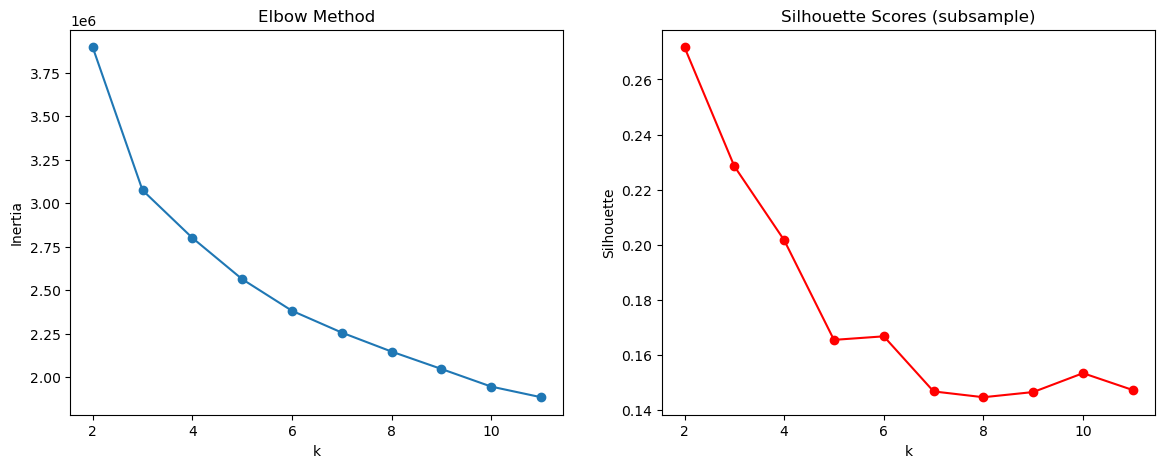

In [68]:

ks = range(2, 12) 
inertias = []
silhouettes = []

# --- subsample for silhouette ---
max_samples = 8000  # tweak if needed
n_samples = min(max_samples, X_cluster.shape[0])
sil_idx = np.random.choice(X_cluster.shape[0], size=n_samples, replace=False)
X_sil = X_cluster[sil_idx]

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels_full = km.fit_predict(X_cluster)
    inertias.append(km.inertia_)
    
    # silhouette only on subset
    labels_sil = labels_full[sil_idx]
    sil = silhouette_score(X_sil, labels_sil)
    silhouettes.append(sil)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(ks, silhouettes, 'ro-', marker='o')
plt.title("Silhouette Scores (subsample)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()


In [69]:
k = 6

kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
df_cluster["cluster"] = kmeans.fit_predict(X_cluster)

### Plot the clusters

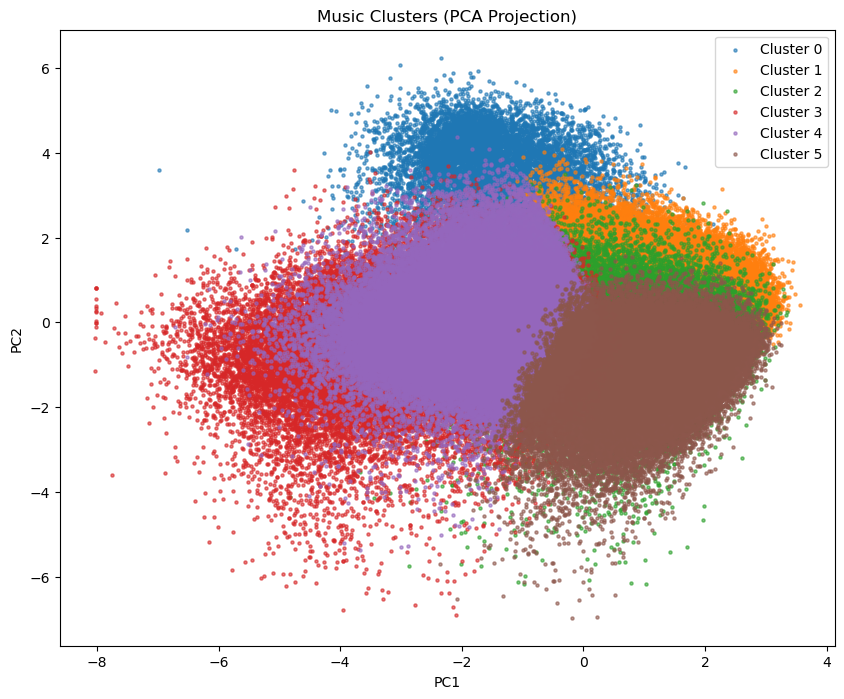

In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

df_cluster["pc1"] = X_pca[:, 0]
df_cluster["pc2"] = X_pca[:, 1]

plt.figure(figsize=(10,8))
for c in range(k):
    subset = df_cluster[df_cluster["cluster"] == c]
    plt.scatter(subset["pc1"], subset["pc2"], s=5, label=f"Cluster {c}", alpha=0.6)

plt.title("Music Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


### Understanding the clusters

In [71]:
cluster_summary = df_cluster.groupby("cluster")[cluster_features].mean()
cluster_summary


,danceability,energy,acousticness,instrumentalness,speechiness,liveness,valence,tempo,loudness,duration_ms
cluster,,,,,,,,,,
0,0.665473,0.335828,0.689059,0.010199,0.851166,0.329967,0.552408,105.016450,-16.910396,191073.255694
1,0.703874,0.666112,0.309270,0.030568,0.084928,0.157679,0.769569,115.670636,-7.981648,216283.762670
2,0.526876,0.660422,0.401759,0.067615,0.094247,0.694272,0.587759,120.434043,-8.699189,241858.174388
3,0.461068,0.296616,0.788373,0.807500,0.059534,0.169379,0.430041,110.232314,-16.081275,232588.080118
4,0.495127,0.309343,0.747444,0.022341,0.052933,0.165313,0.424077,111.080409,-12.730821,217657.251257
5,0.497349,0.741473,0.148020,0.086392,0.073378,0.181633,0.476252,138.066007,-6.971193,251559.778600


In [72]:
cluster_sizes = df_cluster["cluster"].value_counts().sort_index()
cluster_sizes


cluster
0     10888
1    144352
2     27456
3     36134
4    108017
5     95840
Name: count, dtype: int64

In [73]:
hit_rates = df_cluster.groupby("cluster")["is_hit"].mean().sort_values(ascending=False)
hit_counts = df_cluster.groupby("cluster")["is_hit"].sum()
cluster_counts = df_cluster["cluster"].value_counts()

cluster_hit_stats = pd.DataFrame({
    "hit_rate": hit_rates,
    "hit_count": hit_counts,
    "total_count": cluster_counts
})

cluster_hit_stats


,hit_rate,hit_count,total_count
cluster,,,
0,0.001102,12,10888
1,0.043408,6266,144352
2,0.029502,810,27456
3,0.003957,143,36134
4,0.025394,2743,108017
5,0.041747,4001,95840


In [74]:
df_cluster["decade"] = (df_cluster["year"] // 10) * 10

decade_distribution = (
    df_cluster.groupby(["decade", "cluster"]).size()
    .unstack(fill_value=0)
)

decade_distribution


cluster,0,1,2,3,4,5
decade,,,,,,
1900.0,0,1,0,0,0,0
1920.0,806,137,31,1038,525,21
1930.0,690,409,255,1334,1756,45
1940.0,293,531,394,2746,2764,101
1950.0,787,2309,695,3749,7754,401
1960.0,327,6024,1705,3041,10382,1767
1970.0,1100,8951,2369,2128,10575,5133
1980.0,1214,13497,2411,2123,9470,8424
1990.0,1294,22832,3934,3051,13747,14939


In [75]:
# Show 20 example tracks per cluster
for c in sorted(df_cluster["cluster"].unique()):
    print(f"\n=== CLUSTER {c} EXAMPLES ===")
    display(df_cluster[df_cluster["cluster"] == c]
            [["name", "artists", "year", ]]
            .sample(20, random_state=42))



=== CLUSTER 0 EXAMPLES ===


,name,artists,year
286013,"Kanalresan, del 6",['Pelle Svanslös'],1978.0
229379,Askepott,['Eventyr lest av Sverre Holm'],2000.0
388038,'Ambáhan,['Hanunóo man'],1953.0
382784,Kapitel 168 - Die drei Ehen der Grand Sophy,"['Georgette Heyer', 'Brigitte Carlsen']",NaN
393338,Chapter 143.2 & Chapter 144.1 - Dolina strachu,['Arthur Conan Doyle'],1927.0
388651,Sangforeningens morgenrødens pinsetur - 2004 R...,['Ebbe Rode'],NaN
333007,An Infinite Number of Monkeys,['Bob Newhart'],NaN
392735,Глава 11. Часть 1.5 - Кюхля,['Юрий Тынянов'],1925.0
351092,Rebaseonu Tunneb Kõrbelõhna,['Tõnu Aav'],1984.0
313515,La Orillita / A Mi Gente,"['José Carbajal ""El Sabalero""']",1984.0



=== CLUSTER 1 EXAMPLES ===


,name,artists,year
195076,O homem bomba,['O Rappa'],NaN
76325,De Sinaloa Para El Mundo,['Calibre 50'],2011.0
46699,Yıldızlar,['Pinhani'],2006.0
291540,Ye Vasantha Midi,"['S. P. Balasubrahmanyam', 'P. Susheela']",1980.0
397031,Over My Shoulder (Roy Fox),['Roy Fox'],NaN
97634,"Me Gusta, Me Gusta","['Silvestre Dangond', 'Juancho De La Espriella']",2008.0
37762,Musica (E Il Resto Scompare),['Elettra Lamborghini'],2020.0
24284,The Reynolds Pamphlet,['Original Broadway Cast of Hamilton'],2015.0
284335,What Makes You Happy - 2004 Remaster,['KC & The Sunshine Band'],1975.0
138365,"Rise And Shine (Arky, Arky)",['Cedarmont Kids'],NaN



=== CLUSTER 2 EXAMPLES ===


,name,artists,year
310379,Sawere Vali Gaadi Se,['Mohammed Rafi'],1967.0
352092,Summer in the Winter,['Lost Tribe'],2004.0
116110,Poor Poor Pitiful Me,['Warren Zevon'],NaN
174943,Pennies From Heaven - previously unreleased,['Dave Brubeck'],NaN
61641,Ya Lo Sé Que Tú Te Vas,['Alejandro Fernández'],2009.0
376348,Ion (FYHYM2018),"['TheRio', 'Kloset']",2018.0
416918,Lord Don't Move the Mountain (Live),['Tami Neilson'],NaN
147255,Life Happens,['Ester Rada'],2014.0
245446,War In Peace,"[""Alexander 'Skip' Spence""]",NaN
387419,El Primer Amor,['Beto Fernán'],NaN



=== CLUSTER 3 EXAMPLES ===


,name,artists,year
237787,New Year Greetings,"['Anonymous', 'Yew Tien Phoon', 'Shanghai Phil...",1993.0
21730,Let Me Die,['Lil Happy Lil Sad'],2017.0
43527,Çaçan - La Rocca,['Çaçan Beats'],2020.0
395597,Soultana maurofora,"['Markos Vamvakaris', 'Apostolos Xatzixristos']",1930.0
330713,Santa Claus Is Comin' To Town,['The Ventures'],NaN
52647,Sunflower River Blues - Re-Recorded Version,['John Fahey'],1998.0
405936,The Trial (2004),['Glenn Murawski'],2020.0
204623,Jeannine,['Dr. Lonnie Smith'],1967.0
227807,Night Streets,['Chick Corea'],1976.0
316215,Unter der Admiralsflagge,['Ernst Mosch und seine Original Egerländer Mu...,1972.0



=== CLUSTER 4 EXAMPLES ===


,name,artists,year
348227,Slávnost úprimných slov,"['Marika Gombitova', 'Vaso Patejdl', 'Ján Leho...",1998.0
384995,Por las Calles de la Vida - Remasterizado,['Francisco Canaro'],1944.0
182581,The Wanderer,['Eden Ahbez'],NaN
408419,Viel schöner Blümelein,"['Johann Hermann Schein', 'Thomanerchor Leipzi...",1930.0
286165,Det jag vill minnas,['Ulf Lundell'],NaN
293359,Way Out West,['Sonny Rollins'],NaN
348895,Krummavísur,"['Aðalsteinn Ásberg', 'Anna Pálína Árnadóttir']",2000.0
342394,When Ev'rything Was Green,['The Brothers Four'],NaN
226684,If You See Me Getting Smaller,['Waylon Jennings'],NaN
145047,L'homme à tête de chou,['Serge Gainsbourg'],1976.0



=== CLUSTER 5 EXAMPLES ===


,name,artists,year
320483,Gleðileg jól (allir saman),['Eyjólfur Kristjánsson'],2006.0
72522,Ti sento,['Ligabue'],NaN
405807,2003,['Richard Youngs & Simon Wickham-Smith'],2006.0
191956,La Muerte De Martín,['El Prodigio'],NaN
135846,Habia una vez un avion,['Cantando con Adriana'],2003.0
71585,Beautiful in my Eyes,['Jericho Rosales'],2009.0
144666,The Nile Song,['Pink Floyd'],1969.0
296194,Verloren Dag,['Noordkaap'],1994.0
181410,Szabadon,['Palya Bea'],2014.0
154926,095 - Botschaft von Geisterhand - Teil 01,['Die drei ???'],NaN


In [76]:
genre_cols = ['genre_pop', 'genre_rock', 'genre_hip_hop',
       'genre_rap', 'genre_r&b', 'genre_soul', 'genre_electronic', 'genre_edm',
       'genre_dance', 'genre_latin', 'genre_country', 'genre_jazz',
       'genre_blues', 'genre_folk', 'genre_metal']
cluster_genre_profile = (
    df_cluster.groupby("cluster")[genre_cols]
    .mean()
)

cluster_genre_profile



,genre_pop,genre_rock,genre_hip_hop,genre_rap,genre_r&b,genre_soul,genre_electronic,genre_edm,genre_dance,genre_latin,genre_country,genre_jazz,genre_blues,genre_folk,genre_metal
cluster,,,,,,,,,,,,,,,
0,0.080915,0.056209,0.028747,0.023420,0.001194,0.004592,0.000184,0.000735,0.003123,0.002755,0.006705,0.012032,0.004133,0.029023,0.001470
1,0.398152,0.214150,0.115662,0.095371,0.014333,0.040741,0.004496,0.005861,0.047322,0.075060,0.033314,0.043061,0.023699,0.054062,0.006962
2,0.337485,0.256337,0.057037,0.047713,0.006847,0.043706,0.005026,0.012748,0.035256,0.060424,0.030194,0.054706,0.036094,0.068364,0.030886
3,0.115182,0.090829,0.003874,0.007361,0.001079,0.054962,0.013782,0.002518,0.013007,0.017712,0.013035,0.182820,0.023025,0.039104,0.009714
4,0.333633,0.195053,0.012063,0.013665,0.008101,0.056112,0.002092,0.001824,0.012785,0.034161,0.049677,0.114686,0.042114,0.109427,0.005694
5,0.413700,0.385632,0.063157,0.062333,0.010465,0.021901,0.009380,0.016058,0.060872,0.057074,0.028829,0.023028,0.029476,0.048351,0.090755


#### Conclusion: clusters not useful

## Feature Importances by Decade

In [77]:
decade_models = {}
decade_importances = {}

audio_features = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'key', 'explicit'
]


feature_names = list(X.columns)  

for decade, df_dec in decade_dfs.items():

    
    df_dec = df_dec.dropna(subset=audio_features + ['is_hit'])

    X_dec = df_dec[audio_features]
    y_dec = df_dec['is_hit']

    model = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    )

    model.fit(X_dec, y_dec)

    decade_models[decade] = model
    decade_importances[decade] = model.feature_importances_

### importances in table

In [78]:
for decade, model in decade_models.items():
    importances = model.feature_importances_
    
    # Pair importance values with feature names
    imp_pairs = list(zip(feature_names, importances))
    
    # Sort descending
    imp_pairs.sort(key=lambda x: x[1], reverse=True)
    
    # Take top 5
    top5 = imp_pairs[:5]

    print(f"\n📀 Top 5 Features in {decade}:")
    for feature, score in top5:
        print(f"   {feature:30s}  {score:.4f}")



📀 Top 5 Features in 1960:
   key                             0.2188
   loudness                        0.1527
   energy                          0.1108
   explicit                        0.1049
   acousticness                    0.0749

📀 Top 5 Features in 1970:
   key                             0.1931
   energy                          0.1095
   explicit                        0.1015
   duration_ms                     0.0988
   loudness                        0.0927

📀 Top 5 Features in 1980:
   key                             0.2303
   duration_ms                     0.1099
   energy                          0.0995
   loudness                        0.0976
   explicit                        0.0922

📀 Top 5 Features in 1990:
   liveness                        0.1634
   key                             0.1562
   duration_ms                     0.1092
   energy                          0.0908
   speechiness                     0.0787

📀 Top 5 Features in 2000:
   liveness              

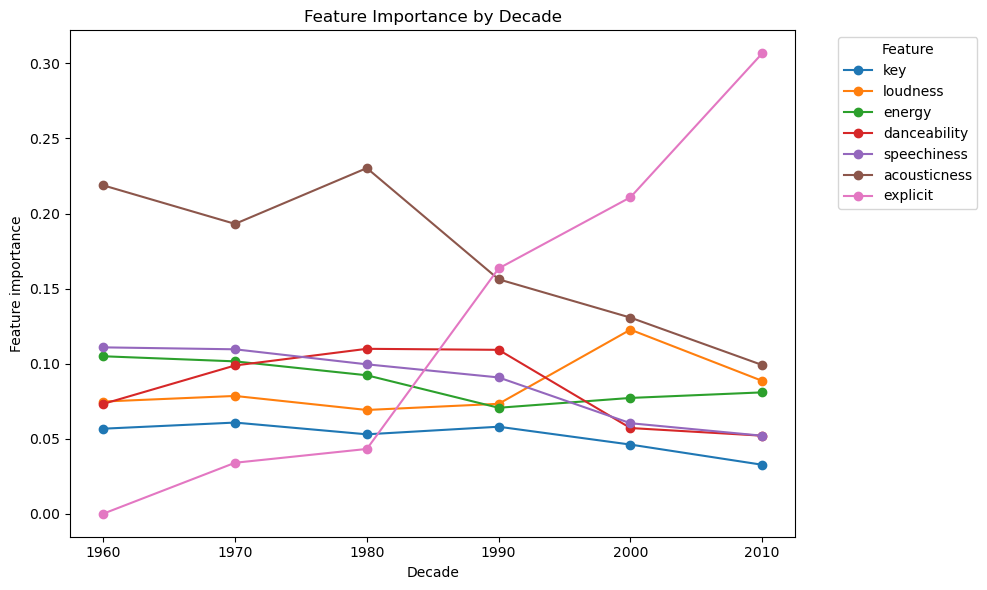

In [ ]:
features_to_show = [
    "key",
    "loudness",
    "energy",
    "danceability",
    "speechiness",
    "acousticness",
    "explicit"
]

importance_by_decade = {}

for decade, model in decade_models.items():
    cols = list(model.feature_names_in_)
    s = pd.Series(model.feature_importances_, index=cols)

    # Keep only the features to show
    importance_by_decade[decade] = s.reindex(features_to_show).fillna(0)

# Build DataFrame
imp_df = pd.DataFrame.from_dict(importance_by_decade, orient="index")

# Ensure decades are in order
imp_df = imp_df.sort_index()

# ---- Grouped bar chart ----
ax = imp_df.plot(marker = "o", figsize=(10, 6))
ax.set_xlabel("Decade")
ax.set_ylabel("Feature importance")
ax.set_title("Feature Importance by Decade")
ax.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [80]:
print(model.feature_names_in_)


['danceability' 'energy' 'loudness' 'speechiness' 'acousticness'
 'instrumentalness' 'liveness' 'valence' 'tempo' 'key' 'explicit']


## Playlist Rater

In [102]:

FEATURE_COLS = feature_cols + fame_features 

fake_playlist = df_model.sample(30, random_state=45).copy()

def make_feature_matrix(df, feature_cols=FEATURE_COLS):
    X = df.copy()

    # 1) Add any missing feature columns (as 0)
    for col in feature_cols:
        if col not in X.columns:
            X[col] = 0

    # 2) Drop extra columns not used by the model, keep only feature_cols
    X = X[feature_cols].copy()

    # 3) Ensure numeric and handle NaNs
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    X = X.fillna(0)

    # 4) Cast to float32 to be safe with XGBoost
    X = X.astype('float32')

    return X


In [103]:
def score_playlist(fake_playlist,
                   model=best_xgb_full,
                   feature_cols=FEATURE_COLS,
                   threshold= best_threshold_full):
    """
    df_playlist_enriched: dataframe with all necessary engineered features
                          (same pipeline as df_model)
    model: trained classifier (best_xgb_full)
    threshold: optional probability threshold for "predicted hit" flag
    """

    # Build feature matrix
    X_pl = make_feature_matrix(fake_playlist)

    # Predict probabilities
    probs = model.predict_proba(X_pl)[:, 1]

    # Attach scores back to dataframe
    df_scores = fake_playlist.copy()
    df_scores['hit_score'] = probs
    df_scores["hit_score_pct"] = (df_scores["hit_score"] * 100).round(1)
    df_scores["predicted_hit"] = (df_scores["hit_score"] >= threshold).astype(int)

    # Optional binary prediction
    if threshold is not None:
        df_scores['predicted_hit'] = (probs >= threshold).astype(int)
    else:
        df_scores['predicted_hit'] = (probs >= 0.5).astype(int)

    # Playlist-level summary
    summary = {
        "Tracks in playlist": int(len(df_scores)),
        "Average hit score (%)": float(df_scores["hit_score_pct"].mean().round(1)),
        "Median hit score (%)": float(df_scores["hit_score_pct"].median().round(1)),
        "Highest track score (%)": float(df_scores["hit_score_pct"].max().round(1)),
        "Lowest track score (%)": float(df_scores["hit_score_pct"].min().round(1)),
        "Predicted hits (count)": int(df_scores["predicted_hit"].sum()),
        "Predicted hits (%)": float((df_scores["predicted_hit"].mean() * 100).round(1)),
    }

    return df_scores, summary


In [104]:

df_scored, summary = score_playlist(fake_playlist, threshold=best_threshold)


# IMPORTANT: fake_playlist already has all engineered features
# (since it's from df_modern/df_model)

best_threshold = best_threshold_full  # from xgb full

df_scored, summary = score_playlist(fake_playlist, threshold=best_threshold)

print("Playlist summary:")
for k, v in summary.items():
    print(f"  {k}: {v}")

# Show top 'hit-like' songs in the fake playlist
cols_to_show = ['name', 'artist_clean', 'year', 'hit_score', 'predicted_hit']
df_scored[cols_to_show].sort_values('hit_score', ascending=False).head(10)


Playlist summary:
  Tracks in playlist: 30
  Average hit score (%): 15.0
  Median hit score (%): 4.099999904632568
  Highest track score (%): 93.30000305175781
  Lowest track score (%): 0.699999988079071
  Predicted hits (count): 1
  Predicted hits (%): 3.3


,name,artist_clean,year,hit_score,predicted_hit
2017,My Love Is Your Love,whitney houston,1998.0,0.933143,1
14594,Walking The Wire,imagine dragons,2017.0,0.841153,0
7807,Break Away,the beach boys,1975.0,0.755140,0
28830,Back from the Dead,skillet,2016.0,0.484159,0
181113,A Fine Romance,frank sinatra,1960.0,0.299834,0
134817,Rapunzel,daniela mercury,1991.0,0.165136,0
213682,Silver Wheels,heart,1980.0,0.132848,0
47339,Free (feat. Emeli Sandé),rudimental,2013.0,0.123426,0
225460,Canción de Amor,el cuarteto de nos,2004.0,0.100544,0
99445,Fuego En Tu Piel - Duranguense,los primos mx,2008.0,0.086675,0


### Importing real spotify playlist

In [105]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.exceptions import SpotifyException

SPOTIPY_CLIENT_ID = "e05e9785b20e45b6a812696ba9c9c6ab"
SPOTIPY_CLIENT_SECRET = "6eec160d478e4d878a3d5f0b8cba8ee4"

SPOTIPY_REDIRECT_URI = "http://127.0.0.1:8888/callback"

SCOPE = "playlist-read-private playlist-read-collaborative"

sp = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        client_id=SPOTIPY_CLIENT_ID,
        client_secret=SPOTIPY_CLIENT_SECRET,
        redirect_uri=SPOTIPY_REDIRECT_URI,
        scope=SCOPE,
        show_dialog=True,
        open_browser=True,
    )
)



In [106]:
me = sp.current_user()
print("Logged in as:", me["display_name"], "(", me["id"], ")")

Logged in as: Jack Wood ( 12102330650 )


In [107]:
def extract_playlist_id(playlist_ref: str) -> str:
    """
    Accepts:
      - plain ID: "37i9dQZF1DXcBWIGoYBM5M"
      - full URL: "https://open.spotify.com/playlist/37i9dQZF1DXcBWIGoYBM5M?..."
    Returns the bare playlist ID.
    """
    if "open.spotify.com/playlist" in playlist_ref:
        m = re.search(r"playlist/([a-zA-Z0-9]+)", playlist_ref)
        if m:
            return m.group(1)
    return playlist_ref


def load_playlist_tracks(playlist_ref: str, sp_client) -> pd.DataFrame:
    """
    Pull all tracks from a playlist and basic track/artist metadata.
    Returns df with columns: track_id, track_name, artist_name, artist_id, album_release_date.
    """
    playlist_id = extract_playlist_id(playlist_ref)

    items = []
    limit = 100
    offset = 0

    while True:
        results = sp_client.playlist_items(
            playlist_id=playlist_id,
            additional_types=("track",),
            limit=limit,
            offset=offset
        )
        batch = results.get("items", [])
        if not batch:
            break

        for item in batch:
            track = item.get("track")
            if track is None:
                continue
            if track.get("type") != "track":
                continue  # skip podcasts, etc.

            tid = track.get("id")
            tname = track.get("name")
            artists = track.get("artists", [])
            if not artists:
                continue
            main_artist = artists[0]
            aid = main_artist.get("id")
            aname = main_artist.get("name")

            album = track.get("album", {})
            release_date = album.get("release_date")

            items.append(
                {
                    "track_id": tid,
                    "track_name": tname,
                    "artist_id": aid,
                    "artist_name": aname,
                    "album_release_date": release_date,
                }
            )

        if results.get("next") is None:
            break

        offset += limit

    df = pd.DataFrame(items)
    print(f"Loaded {len(df)} playlist tracks (with ids).")
    return df


### get audio features if possible

In [ ]:
def fetch_audio_features(track_ids, sp_client) -> pd.DataFrame:
    """
    Batch-fetch audio features for a list of track IDs.

    NOTE (2025): Spotify turned off its API sadly: Spotify's /v1/audio-features endpoint now returns 403
    for many apps (deprecated / restricted). If that happens, just
    return an empty DataFrame and continue without audio features.
    """
    track_ids = [tid for tid in track_ids if tid is not None]

    audio_rows = []
    try:
        for i in range(0, len(track_ids), 100):
            batch = track_ids[i:i+100]
            feats = sp_client.audio_features(batch)
            for af in feats:
                if af is None:
                    continue
                audio_rows.append(af)

        df_audio = pd.DataFrame(audio_rows)
        return df_audio

    except SpotifyException as e:
        print("⚠️ Could not fetch audio features (likely 403/deprecated endpoint). "
              "Continuing without audio features.")
        print(e)
        # Return empty DF so downstream code can handle missing columns
        return pd.DataFrame()

def fetch_artist_info(artist_ids, sp_client) -> pd.DataFrame:
    """
    Batch-fetch artist popularity, followers, and genres.
    """
    artist_rows = []
    artist_ids = list({aid for aid in artist_ids if aid is not None})

    for i in range(0, len(artist_ids), 50):
        batch = artist_ids[i:i+50]
        arts = sp_client.artists(batch)["artists"]
        for art in arts:
            if art is None:
                continue
            artist_rows.append(
                {
                    "artist_id": art["id"],
                    "artist_popularity_raw": art.get("popularity", 0),
                    "artist_followers_raw": art.get("followers", {}).get("total", 0),
                    "artist_genres_raw": art.get("genres", []),
                }
            )

    df_art = pd.DataFrame(artist_rows)
    return df_art


### make sure features match

In [ ]:
def follower_bucket(n_followers: float) -> str:
    """
    Same logic used when building followers_* features.
    Adjust thresholds if needed to match original code.
    """
    if n_followers >= 5_000_000:
        return "star"
    elif n_followers >= 1_000_000:
        return "big"
    elif n_followers >= 200_000:
        return "medium"
    elif n_followers >= 20_000:
        return "small"
    else:
        return "tiny"


def genres_to_flags(genre_list):
    """
    Map a list of Spotify genres to genre_* flags.
    Treat genres case-insensitively and search substrings.
    """
    if not isinstance(genre_list, list):
        genre_list = []

    g = " ".join(genre_list).lower()

    return {
        "genre_pop":       int("pop" in g),
        "genre_rock":      int("rock" in g),
        "genre_hip_hop":   int("hip hop" in g or "hip-hop" in g or "rap" in g),
        "genre_rap":       int("rap" in g),
        "genre_r&b":       int("r&b" in g or "rnb" in g),
        "genre_soul":      int("soul" in g),
        "genre_electronic":int("electronic" in g or "electro" in g),
        "genre_edm":       int("edm" in g),
        "genre_dance":     int("dance" in g),
        "genre_latin":     int("latin" in g),
        "genre_country":   int("country" in g),
        "genre_jazz":      int("jazz" in g),
        "genre_blues":     int("blues" in g),
        "genre_folk":      int("folk" in g),
        "genre_metal":     int("metal" in g),
        "num_genres":      len(genre_list),
    }


def tempo_bucket_code_func(t):
    if pd.isna(t):
        return 1  # treat missing as 'mid'
    t = float(t)
    if t < 80:   return 0  # slow
    if t < 110:  return 1  # mid
    if t < 140:  return 2  # upbeat
    return 3              # fast


def enrich_playlist_for_model(df_playlist_meta, sp_client) -> pd.DataFrame:
    # 1) audio features (may fail / be empty)
    df_audio = fetch_audio_features(df_playlist_meta["track_id"].tolist(), sp_client)

    # 2) artist info
    df_art = fetch_artist_info(df_playlist_meta["artist_id"].tolist(), sp_client)

    # 3) start from playlist meta
    df = df_playlist_meta.copy()

    # Merge audio features only if they exist
    if not df_audio.empty:
        df = df.merge(df_audio, left_on="track_id", right_on="id", how="left")

    # Merge artist info
    df = df.merge(df_art, on="artist_id", how="left")

    # ensure raw audio feature columns exist even if audio-features failed
    audio_cols = [
        "energy",
        "valence",
        "danceability",
        "loudness",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "tempo",
        "duration_ms",
    ]
    for col in audio_cols:
        if col not in df.columns:
            df[col] = np.nan

    # 4) basic fields: year / decade
    def extract_year(date_str):
        try:
            return int(str(date_str)[:4])
        except:
            return np.nan

    df["year"] = df["album_release_date"].apply(extract_year)
    df["decade"] = (df["year"] // 10) * 10

    # 5) fame features
    df["artist_popularity"] = df["artist_popularity_raw"].fillna(0).astype(float)
    df["artist_followers"] = df["artist_followers_raw"].fillna(0).astype(float)
    df["artist_followers_log"] = np.log1p(df["artist_followers"].clip(lower=0))

    df["followers_bucket"] = df["artist_followers"].apply(follower_bucket)
    for bucket in ["tiny", "small", "medium", "big", "star"]:
        df[f"followers_{bucket}"] = (df["followers_bucket"] == bucket).astype(int)

    # 6) genres flags
    genre_flags = df["artist_genres_raw"].apply(genres_to_flags).apply(pd.Series)
    df = pd.concat([df, genre_flags], axis=1)

    # 7) simple "is_cover" placeholder: assume 0 (original)
    df["is_cover"] = 0

    # 8) engineered features
    # These will just be NaN if the base audio features are NaN
    df["energy_valence"] = df["energy"] * df["valence"]
    df["dance_energy"] = df["danceability"] * df["energy"]
    df["loudness_energy"] = df["loudness"] * df["energy"]
    df["speech_energy"] = df["speechiness"] * df["energy"]

    df["energy_minus_valence"] = df["energy"] - df["valence"]
    df["dance_minus_acoustic"] = df["danceability"] - df["acousticness"]
    df["instrumental_minus_speech"] = df["instrumentalness"] - df["speechiness"]

    df["log_tempo"] = np.log1p(df["tempo"].clip(lower=0))
    df["log_duration"] = np.log1p(df["duration_ms"].clip(lower=0))

    df["tempo_bucket_code"] = df["tempo"].apply(tempo_bucket_code_func)

    return df


### add in playlist

In [ ]:
# 1) Ask the model what features it was actually trained with
model_features = list(best_xgb_full.get_booster().feature_names)
print("Model expects", len(model_features), "features")
# 2) Load + enrich playlist
my_playlist_url = "https://open.spotify.com/playlist/58PzH5E1NBOs6BEvsheJ6Q?si=8b469fc0a2754b5f"
df_playlist_meta = load_playlist_tracks(my_playlist_url, sp)
df_playlist_enriched = enrich_playlist_for_model(df_playlist_meta, sp)

# 3) Ensure every model feature exists in df_playlist_enriched
for col in model_features:
    if col not in df_playlist_enriched.columns:
        df_playlist_enriched[col] = 0

# 4) Make sure types are numeric for model features
df_playlist_enriched[model_features] = df_playlist_enriched[model_features].apply(
    pd.to_numeric, errors="coerce"
).fillna(0)

# 5) Build X_pl in exact model feature order
X_pl = df_playlist_enriched[model_features]

# 6) Predict probabilities
y_pl_probs = best_xgb_full.predict_proba(X_pl)[:, 1]

# Use F1-optimal threshold
best_threshold = best_threshold_full

df_playlist_enriched["hit_score"] = y_pl_probs
df_playlist_enriched["predicted_hit"] = (df_playlist_enriched["hit_score"] >= best_threshold).astype(int)


Model expects 50 features


HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=22VHOlVYBqytsrAqV8yXBK,3CUpbtzoKSma5AnP7kLoEv,2SXx7Ofa79CeJfio98aJcG,1JDIArrcepzWDTAWXdGYmP,0JmnkIqdlnUzPaf8sqBRs3,2TeYAizye4GlmzQq5zyf91,1Jg3XdrCOZ5rrirIOggdtW,2ROQe6QkIXODJRx0y8UjzV,4MjDJD8cW7iVeWInc2Bdyj,59SaaebqvxHSui4LbocJYI,3HMOMdRPywfouYx5B4PvaH,0IP9U6sTH3BBbmczskyxvm,5xb7S58TQ4LHkFQQ7GWvPV,6RtZ4Kvk7apHXWFqiI0HLO,1bfU9OBjfTdgK4GCixvT81,41QBT1Al5RQ9u9UIHOuXnj,3I0g4RFjhqsBvbRUjO5o1Q,7MkysLvt3L8UFji2PceoFU,0aV5uARAknQgYhBaK944FP,0gL0Xf8CN95HmgfEYYLRZV,2VBLFxCUyFp5BfmsZpxcis,4f3nDjgqXurMryYBSp0TZD,7z8HxlmDrDoQsKlzEGZw3B,2OMqSRS11ly56zg9u5za6c,3Nq8bUC45N7u3NQ2EkFVZp,3uzOTvWDZoafuN04gw6UI1,745sNpjWbAxo2MA2zSYbyD,2LXISHBkx8FyoxCBkckh19,0fSk2hA0sKGnWtiHuniOAm,1PKxURn2ix43IXZkp3n2I1,4At1qbqCOJ9WFbvpWTOOY4,6iwXzkhrOgokSyTmKZQvym,3CkaqnqHF4NCMypM5AcVqq,3IwadYiQKN7O51JgIH9PBC,4yK3xXuNrkSq0OVjKUaCkY,4lSCs7NXjDpMqWiGm4LD0Z,2joEpsXflccZD0ZwKEdz5m,1JKioiu4WVtEZojt2OdfmR,2DccHqTquzubziHAPZRdct,5jfhLCSIFUO4ndzNRh4w4G,0WFS2dD69nO

Loaded 88 playlist tracks (with ids).
⚠️ Could not fetch audio features (likely 403/deprecated endpoint). Continuing without audio features.
http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=22VHOlVYBqytsrAqV8yXBK,3CUpbtzoKSma5AnP7kLoEv,2SXx7Ofa79CeJfio98aJcG,1JDIArrcepzWDTAWXdGYmP,0JmnkIqdlnUzPaf8sqBRs3,2TeYAizye4GlmzQq5zyf91,1Jg3XdrCOZ5rrirIOggdtW,2ROQe6QkIXODJRx0y8UjzV,4MjDJD8cW7iVeWInc2Bdyj,59SaaebqvxHSui4LbocJYI,3HMOMdRPywfouYx5B4PvaH,0IP9U6sTH3BBbmczskyxvm,5xb7S58TQ4LHkFQQ7GWvPV,6RtZ4Kvk7apHXWFqiI0HLO,1bfU9OBjfTdgK4GCixvT81,41QBT1Al5RQ9u9UIHOuXnj,3I0g4RFjhqsBvbRUjO5o1Q,7MkysLvt3L8UFji2PceoFU,0aV5uARAknQgYhBaK944FP,0gL0Xf8CN95HmgfEYYLRZV,2VBLFxCUyFp5BfmsZpxcis,4f3nDjgqXurMryYBSp0TZD,7z8HxlmDrDoQsKlzEGZw3B,2OMqSRS11ly56zg9u5za6c,3Nq8bUC45N7u3NQ2EkFVZp,3uzOTvWDZoafuN04gw6UI1,745sNpjWbAxo2MA2zSYbyD,2LXISHBkx8FyoxCBkckh19,0fSk2hA0sKGnWtiHuniOAm,1PKxURn2ix43IXZkp3n2I1,4At1qbqCOJ9WFbvpWTOOY4,6iwXzkhrOgokSyTmKZQvym,3CkaqnqHF4NCMypM5AcVqq,3IwadYiQKN7O51JgIH9PBC,4

### Display results

In [ ]:
def label_from_score(score_pct: float) -> str:
    """
    Map 0–100 playlist score to a fun label.
    You can tweak boundaries + text however you want.
    """
    if score_pct < 20:
        return "⚗️ Uniquely Niche — deep cuts only"
    elif score_pct < 50:
        return "🌱 Pretty unique — not bad"
    elif score_pct < 70:
        return "😎 Solid mix — balanced taste"
    elif score_pct < 85:
        return "🔥 Very mainstream — a bit basic"
    else:
        return "🚨 Algorithm’s Favorite Child — playlist built by Spotify itself 🚨"


### Playlist scoring

In [ ]:
# Background mean probability (mu): 0.12040581
# Background std probability (sigma): 0.22334741

def summarize_playlist(df_playlist_enriched, k=20, soft_threshold=0.70):
    
    MU_BG = 0.29   
    SIGMA_BG = 0.1
    
    scores = df_playlist_enriched["hit_score"]

    mean_score = scores.mean()

    # Make sure k isn't bigger than playlist length
    k_eff = min(k, len(scores))
    top_k_mean = scores.nlargest(k_eff).mean()

    playlist_index = 0.2 * mean_score + 0.8 * top_k_mean

    df_playlist_enriched["predicted_hit_soft"] = (
        df_playlist_enriched["hit_score"] >= soft_threshold
    ).astype(int)
    hit_rate_soft = df_playlist_enriched["predicted_hit_soft"].mean()

    # z score 
    z = (playlist_index - MU_BG) / SIGMA_BG
    
    rating = 40 + 20 * z
    rating = float(np.clip(rating, 0, 100).round(1))
    final_score_pct = round(playlist_index * 100, 1)
    label = label_from_score(rating)

    summary = {
        "mean_score": mean_score,
        "top_k_mean": top_k_mean,
        "playlist_index": playlist_index,
        "final_score_pct": rating, # either rating (z score), or final_score_pct (regular index)
        "label": label,
        "soft_threshold": soft_threshold,
        "soft_hit_rate": hit_rate_soft,
    }
    return summary


### Test rating

In [ ]:
test_playlists = {
    "2010s Hits": "https://open.spotify.com/playlist/5XALIurWS8TuF6kk8bj438?si=-iMclRPNRwC7hcf8aFKtug",
    "2010 pop car bangers": "https://open.spotify.com/playlist/26MY3qVKQFBSqNMBshJZs8?si=Fk-ulDj3R8yV6nrIn9JYkw",
    "2010 indie": "https://open.spotify.com/playlist/3sCXpyujWoLScwx3HhvRtf?si=SIAcEXb6QJeZLPr4_lly-w",
    "CEE": "https://open.spotify.com/playlist/58PzH5E1NBOs6BEvsheJ6Q?si=f95b38c895e349b7",
    "Maria": "https://open.spotify.com/playlist/1FcXT8N59wZjoKxwNfwCnp?si=224819eadab04990",
    "Russian": "https://open.spotify.com/playlist/4FnwqKcKxaSU2iPQUIXHUs?si=8057711d4e074381",
    "1980s": "https://open.spotify.com/playlist/4XH0t7xDZa4mXPxbT4hbR3?si=_vdIuqkKTHejgy8aaKE1xw",
    "summer fun": "https://open.spotify.com/playlist/2CXsqS5Mg6rJQSUVRiHh1a?si=7a87db6179b143e3",
    "default": "https://open.spotify.com/playlist/5xbg1Y0wWC0daWLpq0cesL?si=02378546eecf4a02",
}


def batch_test_playlists(playlist_dict):
    """
    playlist_dict: { "name": "spotify_url", ... }
    Runs the scoring pipeline on each playlist and prints a summary line.
    """

    print("\n=== Batch Playlist Test ===\n")

    results = {}

    for name, url in playlist_dict.items():
        print(f"▶️  Loading playlist: {name}")

        # 1. Load playlist into a DataFrame of tracks
        df_pl_pre = load_playlist_tracks(url, sp)    
        df_pl = enrich_playlist_for_model(df_pl_pre, sp)

        if df_pl is None or len(df_pl) == 0:
            print(f"   ❌ Could not load playlist: {name}\n")
            continue

        # 2. Score playlist (track-level)
        df_scored, _ = score_playlist(df_pl)

        # 3. Summarize playlist (playlist-level)
        summary = summarize_playlist(df_scored)

        idx = summary["playlist_index"]
        pct = summary["final_score_pct"]

        # 4. Print result
        print(f"🎧 {name}")
        print(f"   Playlist Hit Index: {idx:.3f} ({pct:.1f}%)\n")

        # 5. Store for later if needed
        results[name] = {
            "index": idx,
            "score_pct": pct,
            "summary": summary
        }

    return results


In [114]:
results = batch_test_playlists(test_playlists)



=== Batch Playlist Test ===

▶️  Loading playlist: 2010s Hits


HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4G8gkOterJn0Ywt6uhqbhp,0IkKz2J93C94Ei4BvDop7P,1CkvWZme3pRgbzaxZnTl5X,6sy3LkhNFjJWlaeSMNwQ62,7qiZfU4dY1lWllzX7mPBI3,0tgVpDi06FyKpA1z0VMD4v,4wCmqSrbyCgxEXROQE6vtV,5jrdCoLpJSvHHorevXBATy,32OlwWuMpZ6b0aN2RZOeMS,6V1bu6o1Yo5ZXnsCJU8Ovk,0W4Kpfp1w2xkY3PrV714B7,3KkXRkHbMCARz0aVfEt68P,7LcfRTgAVTs5pQGEQgUEzN,7BqBn9nzAq8spo5e7cZ0dJ,1DqdF42leyFIzqNDv9CjId,3U4isOIWM3VvDubwSI3y7a,4h8VwCb1MTGoLKueQ1WgbD,5p7ujcrUXASCNwRaWNHR1C,5Nm9ERjJZ5oyfXZTECKmRt,7BKLCZ1jbUBVqRi2FVlTVw,7AqISujIaWcY3h5zrOqt5v,7iDa6hUg2VgEL1o1HjmfBn,5xhQChGGhKLWqBqX4XhtYE,0jHSdjxn9LfzNL0WkDu93W,4QNpBfC0zvjKqPJcyqBy9W,3TGRqZ0a2l1LRblBkJoaDx,34gCuhDGsG4bRPIf9bb02f,2dpaYNEQHiRxtZbfNsse99,58q2HKrzhC3ozto2nDdN4z,1WkMMavIMc4JZ8cfMmxHkI,2xLMifQCjDGFmkHkpNLD9h,4HlFJV71xXKIGcU3kRyttv,2d8JP84HNLKhmd6IYOoupQ,0n4bITAu0Y0nigrz3MFJMb,4YMqbFcDIFiCBd02PzUBcM,285pBltuF7vW8TeWk8hdRR,0KKkJNfGyhkQ5aFogxQAPU,1i1fxkWeaMmKEB4T7zqbzK,60nZcImufyMA1MKQY3dcCH,5jE48hhRu8E6zBDPRSkEq7,11EX5yhxr9I

Loaded 500 playlist tracks (with ids).
⚠️ Could not fetch audio features (likely 403/deprecated endpoint). Continuing without audio features.
http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4G8gkOterJn0Ywt6uhqbhp,0IkKz2J93C94Ei4BvDop7P,1CkvWZme3pRgbzaxZnTl5X,6sy3LkhNFjJWlaeSMNwQ62,7qiZfU4dY1lWllzX7mPBI3,0tgVpDi06FyKpA1z0VMD4v,4wCmqSrbyCgxEXROQE6vtV,5jrdCoLpJSvHHorevXBATy,32OlwWuMpZ6b0aN2RZOeMS,6V1bu6o1Yo5ZXnsCJU8Ovk,0W4Kpfp1w2xkY3PrV714B7,3KkXRkHbMCARz0aVfEt68P,7LcfRTgAVTs5pQGEQgUEzN,7BqBn9nzAq8spo5e7cZ0dJ,1DqdF42leyFIzqNDv9CjId,3U4isOIWM3VvDubwSI3y7a,4h8VwCb1MTGoLKueQ1WgbD,5p7ujcrUXASCNwRaWNHR1C,5Nm9ERjJZ5oyfXZTECKmRt,7BKLCZ1jbUBVqRi2FVlTVw,7AqISujIaWcY3h5zrOqt5v,7iDa6hUg2VgEL1o1HjmfBn,5xhQChGGhKLWqBqX4XhtYE,0jHSdjxn9LfzNL0WkDu93W,4QNpBfC0zvjKqPJcyqBy9W,3TGRqZ0a2l1LRblBkJoaDx,34gCuhDGsG4bRPIf9bb02f,2dpaYNEQHiRxtZbfNsse99,58q2HKrzhC3ozto2nDdN4z,1WkMMavIMc4JZ8cfMmxHkI,2xLMifQCjDGFmkHkpNLD9h,4HlFJV71xXKIGcU3kRyttv,2d8JP84HNLKhmd6IYOoupQ,0n4bITAu0Y0nigrz3MFJMb,

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0HPD5WQqrq7wPWR7P7Dw1i,4356Typ82hUiFAynbLYbPn,3ZFTkvIE7kyPt6Nu3PEa7V,7LP4Es66zdY7CyjepqmvAg,0SiywuOBRcynK0uKGWdCnn,2yPoXCs7BSIUrucMdK5PzV,0CAfXk7DXMnon4gLudAp7J,5rb9QrpfcKFHM1EUbSIurX,66ZcOcouenzZEnzTJvoFmH,4QNpBfC0zvjKqPJcyqBy9W,6I9VzXrHxO9rA9A5euc8Ak,1Jo0Zg7XlrA6z0mFTZVdkn,0O45fw2L5vsWpdsOdXwNAR,6KOEK6SeCEZOQkLj5M1PxH,4fixebDZAVToLbUCuEloa2,4DvhkX2ic4zWkQeWMwQ2qf,3bC1ahPIYt1btJzSSEyyrF,0Oe49j06Bjrxs8PltuVeaW,2oENJa1T33GJ0w8dC167G4,2PpruBYCo4H7WOBJ7Q2EwM,3avYqdwHKEq8beXbeWCKqJ,6vc2Jq2vaGu8z326kSrw92,1oHNvJVbFkexQc0BpQp7Y4,1D066zixBwqFYqBhKgdPzp,0qOnSQQF0yzuPWsXrQ9paz,1NpW5kyvO4XrNJ3rnfcNy3,5uHYcK0nbEYgRaFTY5BqnP,3pYDZTJM2tVBUhIRifWVzI,5Q0Nhxo0l2bP3pNjpGJwV1,1fBl642IhJOE5U319Gy2Go,19JdbdEwQI7bCxefMokZO8,1gv4xPanImH17bKZ9rOveR,63rbP24OzfaQCJjsHWZXnY,4r6eNCsrZnQWJzzvFh4nlg,7EQGXaVSyEDsCWKmUcfpLk,6naxalmIoLFWR0siv8dnQQ,3DmW6y7wTEYHJZlLo1r6XJ,21pySLskKIKrhDziCX5ojQ,4RCWB3V8V0dignt99LZ8vH,4cluDES4hQEUhmXj6TXkSo,5jzKL4BDMCl

Loaded 179 playlist tracks (with ids).
⚠️ Could not fetch audio features (likely 403/deprecated endpoint). Continuing without audio features.
http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0HPD5WQqrq7wPWR7P7Dw1i,4356Typ82hUiFAynbLYbPn,3ZFTkvIE7kyPt6Nu3PEa7V,7LP4Es66zdY7CyjepqmvAg,0SiywuOBRcynK0uKGWdCnn,2yPoXCs7BSIUrucMdK5PzV,0CAfXk7DXMnon4gLudAp7J,5rb9QrpfcKFHM1EUbSIurX,66ZcOcouenzZEnzTJvoFmH,4QNpBfC0zvjKqPJcyqBy9W,6I9VzXrHxO9rA9A5euc8Ak,1Jo0Zg7XlrA6z0mFTZVdkn,0O45fw2L5vsWpdsOdXwNAR,6KOEK6SeCEZOQkLj5M1PxH,4fixebDZAVToLbUCuEloa2,4DvhkX2ic4zWkQeWMwQ2qf,3bC1ahPIYt1btJzSSEyyrF,0Oe49j06Bjrxs8PltuVeaW,2oENJa1T33GJ0w8dC167G4,2PpruBYCo4H7WOBJ7Q2EwM,3avYqdwHKEq8beXbeWCKqJ,6vc2Jq2vaGu8z326kSrw92,1oHNvJVbFkexQc0BpQp7Y4,1D066zixBwqFYqBhKgdPzp,0qOnSQQF0yzuPWsXrQ9paz,1NpW5kyvO4XrNJ3rnfcNy3,5uHYcK0nbEYgRaFTY5BqnP,3pYDZTJM2tVBUhIRifWVzI,5Q0Nhxo0l2bP3pNjpGJwV1,1fBl642IhJOE5U319Gy2Go,19JdbdEwQI7bCxefMokZO8,1gv4xPanImH17bKZ9rOveR,63rbP24OzfaQCJjsHWZXnY,4r6eNCsrZnQWJzzvFh4nlg,

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0GO8y8jQk1PkHzS31d699N,4Sfa7hdVkqlM8UW5LsSY3F,57i3M29DWoo7RDk0Tf0LZG,1595LW73XBxkRk2ciQOHfr,2Ml0l8YWJLQhPrRDLpQaDM,2AYEOC02WLhUiOoaig2SEH,0Nk7bSn0MItonkR0GNs3mj,7w87IxuO7BDcJ3YUqCyMTT,5Fli1xRi01bvCjsZvKWro0,25nzKGDiua1lE9Qo5V19GL,1jJci4qxiYcOHhQR247rEU,3FtYbEfBqAlGO46NUDQSAt,6ZrlXT6mUMEgomN128iekU,5JtPGzRgrWxkXX9LoROq3d,0mBkoM8r7KAQzZij5swTUL,5FVd6KXrgO9B3JPmC8OPst,2AT8iROs4FQueDv2c8q2KE,3huV7eiNpaQlCB3LbZi9bB,0grFc6klR3hxoHLcgCYsF4,5lN1EH25gdiqT1SFALMAq1,2MVwrvjmcdt4MsYYLCYMt8,5G1sTBGbZT5o4PNRc75RKI,3kb72STxc2959ZqsTwu52i,2tznHmp70DxMyr2XhWLOW0,6PUIzlqotEmPuBfjbwYWOB,2dLLR6qlu5UJ5gk0dKz0h3,3G6hD9B2ZHOsgf4WfNu7X1,2QjOHCTQ1Jl3zawyYOpxh6,6jrMVRReY24qzCfe1BRrww,1eyzqe2QqGZUmfcPZtrIyt,1aGvLFHJ2shKqO9uycaUcW,2GiJYvgVaD2HtM8GqD9EgQ,4HRa9ZWcmZ8JD7UySPu0wT,6RKGBcDtgzXx21zUjpeu6F,2jnvdMCTvtdVCci3YLqxGY,6nek1Nin9q48AVZcWs9e9D,3GL12BAZFVQPcCOAgPaSsT,7brQHA2CgQpcMBiOlfiXYb,0DAsxISzun85PbsqAfIzeC,6K4t31amVTZDgR3sKmwUJJ,4dTVgHZFPla

Loaded 121 playlist tracks (with ids).
⚠️ Could not fetch audio features (likely 403/deprecated endpoint). Continuing without audio features.
http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0GO8y8jQk1PkHzS31d699N,4Sfa7hdVkqlM8UW5LsSY3F,57i3M29DWoo7RDk0Tf0LZG,1595LW73XBxkRk2ciQOHfr,2Ml0l8YWJLQhPrRDLpQaDM,2AYEOC02WLhUiOoaig2SEH,0Nk7bSn0MItonkR0GNs3mj,7w87IxuO7BDcJ3YUqCyMTT,5Fli1xRi01bvCjsZvKWro0,25nzKGDiua1lE9Qo5V19GL,1jJci4qxiYcOHhQR247rEU,3FtYbEfBqAlGO46NUDQSAt,6ZrlXT6mUMEgomN128iekU,5JtPGzRgrWxkXX9LoROq3d,0mBkoM8r7KAQzZij5swTUL,5FVd6KXrgO9B3JPmC8OPst,2AT8iROs4FQueDv2c8q2KE,3huV7eiNpaQlCB3LbZi9bB,0grFc6klR3hxoHLcgCYsF4,5lN1EH25gdiqT1SFALMAq1,2MVwrvjmcdt4MsYYLCYMt8,5G1sTBGbZT5o4PNRc75RKI,3kb72STxc2959ZqsTwu52i,2tznHmp70DxMyr2XhWLOW0,6PUIzlqotEmPuBfjbwYWOB,2dLLR6qlu5UJ5gk0dKz0h3,3G6hD9B2ZHOsgf4WfNu7X1,2QjOHCTQ1Jl3zawyYOpxh6,6jrMVRReY24qzCfe1BRrww,1eyzqe2QqGZUmfcPZtrIyt,1aGvLFHJ2shKqO9uycaUcW,2GiJYvgVaD2HtM8GqD9EgQ,4HRa9ZWcmZ8JD7UySPu0wT,6RKGBcDtgzXx21zUjpeu6F,

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=22VHOlVYBqytsrAqV8yXBK,3CUpbtzoKSma5AnP7kLoEv,2SXx7Ofa79CeJfio98aJcG,1JDIArrcepzWDTAWXdGYmP,0JmnkIqdlnUzPaf8sqBRs3,2TeYAizye4GlmzQq5zyf91,1Jg3XdrCOZ5rrirIOggdtW,2ROQe6QkIXODJRx0y8UjzV,4MjDJD8cW7iVeWInc2Bdyj,59SaaebqvxHSui4LbocJYI,3HMOMdRPywfouYx5B4PvaH,0IP9U6sTH3BBbmczskyxvm,5xb7S58TQ4LHkFQQ7GWvPV,6RtZ4Kvk7apHXWFqiI0HLO,1bfU9OBjfTdgK4GCixvT81,41QBT1Al5RQ9u9UIHOuXnj,3I0g4RFjhqsBvbRUjO5o1Q,7MkysLvt3L8UFji2PceoFU,0aV5uARAknQgYhBaK944FP,0gL0Xf8CN95HmgfEYYLRZV,2VBLFxCUyFp5BfmsZpxcis,4f3nDjgqXurMryYBSp0TZD,7z8HxlmDrDoQsKlzEGZw3B,2OMqSRS11ly56zg9u5za6c,3Nq8bUC45N7u3NQ2EkFVZp,3uzOTvWDZoafuN04gw6UI1,745sNpjWbAxo2MA2zSYbyD,2LXISHBkx8FyoxCBkckh19,0fSk2hA0sKGnWtiHuniOAm,1PKxURn2ix43IXZkp3n2I1,4At1qbqCOJ9WFbvpWTOOY4,6iwXzkhrOgokSyTmKZQvym,3CkaqnqHF4NCMypM5AcVqq,3IwadYiQKN7O51JgIH9PBC,4yK3xXuNrkSq0OVjKUaCkY,4lSCs7NXjDpMqWiGm4LD0Z,2joEpsXflccZD0ZwKEdz5m,1JKioiu4WVtEZojt2OdfmR,2DccHqTquzubziHAPZRdct,5jfhLCSIFUO4ndzNRh4w4G,0WFS2dD69nO

Loaded 88 playlist tracks (with ids).
⚠️ Could not fetch audio features (likely 403/deprecated endpoint). Continuing without audio features.
http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=22VHOlVYBqytsrAqV8yXBK,3CUpbtzoKSma5AnP7kLoEv,2SXx7Ofa79CeJfio98aJcG,1JDIArrcepzWDTAWXdGYmP,0JmnkIqdlnUzPaf8sqBRs3,2TeYAizye4GlmzQq5zyf91,1Jg3XdrCOZ5rrirIOggdtW,2ROQe6QkIXODJRx0y8UjzV,4MjDJD8cW7iVeWInc2Bdyj,59SaaebqvxHSui4LbocJYI,3HMOMdRPywfouYx5B4PvaH,0IP9U6sTH3BBbmczskyxvm,5xb7S58TQ4LHkFQQ7GWvPV,6RtZ4Kvk7apHXWFqiI0HLO,1bfU9OBjfTdgK4GCixvT81,41QBT1Al5RQ9u9UIHOuXnj,3I0g4RFjhqsBvbRUjO5o1Q,7MkysLvt3L8UFji2PceoFU,0aV5uARAknQgYhBaK944FP,0gL0Xf8CN95HmgfEYYLRZV,2VBLFxCUyFp5BfmsZpxcis,4f3nDjgqXurMryYBSp0TZD,7z8HxlmDrDoQsKlzEGZw3B,2OMqSRS11ly56zg9u5za6c,3Nq8bUC45N7u3NQ2EkFVZp,3uzOTvWDZoafuN04gw6UI1,745sNpjWbAxo2MA2zSYbyD,2LXISHBkx8FyoxCBkckh19,0fSk2hA0sKGnWtiHuniOAm,1PKxURn2ix43IXZkp3n2I1,4At1qbqCOJ9WFbvpWTOOY4,6iwXzkhrOgokSyTmKZQvym,3CkaqnqHF4NCMypM5AcVqq,3IwadYiQKN7O51JgIH9PBC,4

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=7s2hKo8YwYPJCFioojEB7U,7JGdGIZNkesNazi6RRHOmT,7Gsy2uBT0CJwbZ2K9KwTk4,7ba7tnuI3LUsOdyT7TOnFH,7AA6DxOZMQzpFHIUPfP2oS,3i5QyEUyXa9Y7lIklr5sWk,5kUs3EVHCalJewyv29ozfx,3fqwjXwUGN6vbzIwvyFMhx,0hveAq1VSNWo9MQYGMHvFF,7jGrvXXwpmNgJVnz7QS7df,7Fpayy69I0M2Mu8uCiXXVW,6gbl08iVNqLJF4Dqs46i12,15ABFJbl41BsIKFWGKfmZ7 with Params: {} returned 403 due to None


Loaded 13 playlist tracks (with ids).
⚠️ Could not fetch audio features (likely 403/deprecated endpoint). Continuing without audio features.
http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=7s2hKo8YwYPJCFioojEB7U,7JGdGIZNkesNazi6RRHOmT,7Gsy2uBT0CJwbZ2K9KwTk4,7ba7tnuI3LUsOdyT7TOnFH,7AA6DxOZMQzpFHIUPfP2oS,3i5QyEUyXa9Y7lIklr5sWk,5kUs3EVHCalJewyv29ozfx,3fqwjXwUGN6vbzIwvyFMhx,0hveAq1VSNWo9MQYGMHvFF,7jGrvXXwpmNgJVnz7QS7df,7Fpayy69I0M2Mu8uCiXXVW,6gbl08iVNqLJF4Dqs46i12,15ABFJbl41BsIKFWGKfmZ7:
 None, reason: None
🎧 Maria
   Playlist Hit Index: 0.191 (20.3%)

▶️  Loading playlist: Russian


HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1ZTZi0C82lOAbUePQEDucC,63u19bTxqIc8Ce52m5emvc,3YirmMZgtekCpC5wVOzOyB,3XAzPxjc5D87TBYC2gWEmx,53ORJG1CfDX0xo8qyhup6Q,6gLlU592gWHM2UoCyHYQA5,4H2qw8aCRmoJBiEcQy6bRa,4vsCJgcrklpegTcZvRLSYH,1tIdfPm6D8QzT5aXTjwexu,5bNgRiBa3545I8tcn1v6XV,6C2TnCLzUkyQ1L7W1lqcP1,2WFB1PtsrN0UdrVz6UXb2v,1pQ2kVxALZeVLGacpblRKF,66e9iSsVrH2AH6zJPLPdq5,36PeUKdOMxivLrmkHeJ3mn,5jKFnadawzHXGWiLBeboas,4FnLGN3avuCsEyawsR3VBV,2THwAMHgLlqRFvgjoAxEu2,3db5qH9zRSArCojUKRGhKe,1X1MpXPKAaqH0VAr2N18xR,3S8builtTwqNkZzfRBi6Em,2pXPp6CvoHNwTWAAexNBZG,4XJ0xSJtI7HKVe3qqoYX5E,3xKqpvxIr2wFYihn3HtGT0,4Z3QdEJeIqnZVIKZYDkrif,6Mv3sjJlAdRB0mc8bFi3Jj,4Ki1cI7IPprs3NWowHrii2,0MXSymo8sAZ3FYTHSf8zMZ,7L5EubqD4WsUJEd2XgVWUH,2tk94GuXRWWBjF48yWdd59,6W4Eq17oQ5JGUJwUgAuvIq,0l8z2OETZzUILvCuwQ34fM,2FUBn1c0cVsxURQsHwU7U0,3uJbD09ngeYujrB6LlOb0a,4H9XZ3qZnVr7IyUXaorDUt,0M56diRArdi0vRYmLBeltn,6FX6S0Vl6tjRCTnWVqVdto,7k6HFZe3WtGpbNUYY6Hndi,5Wu61zovtY5rqv2R1wlIix,19U6hsEZzmiup2irBjoq7e,6hXTjyns7Vl

Loaded 74 playlist tracks (with ids).
⚠️ Could not fetch audio features (likely 403/deprecated endpoint). Continuing without audio features.
http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=1ZTZi0C82lOAbUePQEDucC,63u19bTxqIc8Ce52m5emvc,3YirmMZgtekCpC5wVOzOyB,3XAzPxjc5D87TBYC2gWEmx,53ORJG1CfDX0xo8qyhup6Q,6gLlU592gWHM2UoCyHYQA5,4H2qw8aCRmoJBiEcQy6bRa,4vsCJgcrklpegTcZvRLSYH,1tIdfPm6D8QzT5aXTjwexu,5bNgRiBa3545I8tcn1v6XV,6C2TnCLzUkyQ1L7W1lqcP1,2WFB1PtsrN0UdrVz6UXb2v,1pQ2kVxALZeVLGacpblRKF,66e9iSsVrH2AH6zJPLPdq5,36PeUKdOMxivLrmkHeJ3mn,5jKFnadawzHXGWiLBeboas,4FnLGN3avuCsEyawsR3VBV,2THwAMHgLlqRFvgjoAxEu2,3db5qH9zRSArCojUKRGhKe,1X1MpXPKAaqH0VAr2N18xR,3S8builtTwqNkZzfRBi6Em,2pXPp6CvoHNwTWAAexNBZG,4XJ0xSJtI7HKVe3qqoYX5E,3xKqpvxIr2wFYihn3HtGT0,4Z3QdEJeIqnZVIKZYDkrif,6Mv3sjJlAdRB0mc8bFi3Jj,4Ki1cI7IPprs3NWowHrii2,0MXSymo8sAZ3FYTHSf8zMZ,7L5EubqD4WsUJEd2XgVWUH,2tk94GuXRWWBjF48yWdd59,6W4Eq17oQ5JGUJwUgAuvIq,0l8z2OETZzUILvCuwQ34fM,2FUBn1c0cVsxURQsHwU7U0,3uJbD09ngeYujrB6LlOb0a,4

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=44hOGg1uFg1XJZGZYNwYmM,5qtLQt2iDjZyDpvpuSqeYi,4o6BgsqLIBViaGVbx5rbRk,5VVwwfK6Cp9IydkhKfJUEq,0GONea6G2XdnHWjNZd6zt3,7aHRctaQ7vjxVTVmY8OhAA,648BMGrt98kUbLo24A4vgj,66S14BkJDxgkYxLl5DCqOz,5vdp5UmvTsnMEMESIF2Ym7,3vV3cr2TpPqFk07zxYUbla,5dRQUolXAVX3BbCiIxmSsf,5zA8vzDGqPl2AzZkEYQGKh,39lSeqnyjZJejRuaREfyLL,7o2CTH4ctstm8TNelqjb51,3MtceBePi1oFKHNwWDyEYB,0Z7O8GMQShj9TJrm2yX1R6,0A4PZuepTcIQVvA5m7R0M1,7eOUHJ2J9hZj3xq08dc2zH,5RsUlxLto4NZbhJpqJbHfN,4y1LsJpmMti1PfRQV9AWWe,0J6mQxEZnlRt9ymzFntA6z,1bvziHOMkyLUc4Vc6QDLcd,5ChkMS8OtdzJeqyybCc9R5,05wIrZSwuaVWhcv5FfqeH0,7Gmd6pPSjCZlsP84T1Sp3D,39shmbIHICJ2Wxnk1fPSdz,58mFu3oIpBa0HLNeJIxsw3,4W4wYHtsrgDiivRASVOINL,1hlveB9M6ijHZRbzZ2teyh,7r2dzOJmihC26x05CPP4Aj,64UioB4Nmwgn2f4cbIpAkl,0PdM2a6oIjqepoEfcJo0RO,79hJaqmVdohltPBNN6BULM,22ML0MuFKfw16WejbxsLOy,05RgAMGypEvqhNs5hPCbMS,2V8KvnD5LVeeDChMWEkSzC,70Z9t1qhytWtG4cCmmi7mU,6gQUbFwwdYXlKdmqRoWKJe,2HXixVqzzm9rEUIMAWzshl with Params: {} returned 403 due t

Loaded 39 playlist tracks (with ids).
⚠️ Could not fetch audio features (likely 403/deprecated endpoint). Continuing without audio features.
http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=44hOGg1uFg1XJZGZYNwYmM,5qtLQt2iDjZyDpvpuSqeYi,4o6BgsqLIBViaGVbx5rbRk,5VVwwfK6Cp9IydkhKfJUEq,0GONea6G2XdnHWjNZd6zt3,7aHRctaQ7vjxVTVmY8OhAA,648BMGrt98kUbLo24A4vgj,66S14BkJDxgkYxLl5DCqOz,5vdp5UmvTsnMEMESIF2Ym7,3vV3cr2TpPqFk07zxYUbla,5dRQUolXAVX3BbCiIxmSsf,5zA8vzDGqPl2AzZkEYQGKh,39lSeqnyjZJejRuaREfyLL,7o2CTH4ctstm8TNelqjb51,3MtceBePi1oFKHNwWDyEYB,0Z7O8GMQShj9TJrm2yX1R6,0A4PZuepTcIQVvA5m7R0M1,7eOUHJ2J9hZj3xq08dc2zH,5RsUlxLto4NZbhJpqJbHfN,4y1LsJpmMti1PfRQV9AWWe,0J6mQxEZnlRt9ymzFntA6z,1bvziHOMkyLUc4Vc6QDLcd,5ChkMS8OtdzJeqyybCc9R5,05wIrZSwuaVWhcv5FfqeH0,7Gmd6pPSjCZlsP84T1Sp3D,39shmbIHICJ2Wxnk1fPSdz,58mFu3oIpBa0HLNeJIxsw3,4W4wYHtsrgDiivRASVOINL,1hlveB9M6ijHZRbzZ2teyh,7r2dzOJmihC26x05CPP4Aj,64UioB4Nmwgn2f4cbIpAkl,0PdM2a6oIjqepoEfcJo0RO,79hJaqmVdohltPBNN6BULM,22ML0MuFKfw16WejbxsLOy,0

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=4agp6oHofabdUedr0B1krj,5a8z2vyIDKMh5qcRG6w9wu,27Es1J9GNKf0pZLy3sdzjl,2Gy7qnDwt8Z3MNxqat4CsK,7kkhw4WZCSQO2RiC5HpmDG,6wFpWuVxpcYWXw7xzj0Wpt,6DDKQhv6C63Ng6GgZ6MqNd,0892wPiVU3lHRaH7L6l7g1,7CvYNbLwC3Zn96l2fbryv8,3VBWOEqwknZm2NQjuvCPUd,19nUjmaqEhWvOtKk72NXGC,2RhHIKSOIXwJPP5nqkNC8e,1ucnuV88gFTfR3BalmznDk,1ijdK77sk67rPi450Pmm8O,3bmBUlK7hmxzhGUCNFcyy6,4hie5sbZpqiMzzZY25dOVp,0IP9U6sTH3BBbmczskyxvm,5zWOZ9upQkrFL5lfZ8GPCh,0VCWi4FUOumziLknRtcDcy,2AEAjWtxiM3rLQDQDdKLxk,5T1tYlzy1CUlbOlYHdlLXM,5JtgrxeDRTTcBsYwKoYb8v,6fsAWAKljmG877puzgHPjt,7eqFExt8qLJZ5wyaVEWIFJ,2RKPrJElcumkY3XEw8ShMF,2c00tSu4BVT2XueXbkCcsK,2akwJRF8Af9hoINSKoXqdG,33yAEqzKXexYM3WlOYtTfQ,54IbnYEdA3ymfxv07WgN3b,0nXgBBZFVdumUIaxszDm1p,4v20N4W83XDJORt7WCedII,6XA0G2iITjC5GgMFaadJ7q,6M2ZYgZ2cdu5oCHGI8wamV,0r2hNA17nXlzIYlyfUmXLL,1Ukxccao1BlWrPhYkcXbwZ,58dSdjfEYNSxte1aNVxuNf,4sOX1nhpKwFWPvoMMExi3q,3sl4dcqSwxHVnLfqwF2jly,1VKWQgq0g2uKtgNfL0ceNM,3xnM0WCRJKk4Iz49rkG5OC,6ygaR0OCPjB

Loaded 61 playlist tracks (with ids).
⚠️ Could not fetch audio features (likely 403/deprecated endpoint). Continuing without audio features.
http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=4agp6oHofabdUedr0B1krj,5a8z2vyIDKMh5qcRG6w9wu,27Es1J9GNKf0pZLy3sdzjl,2Gy7qnDwt8Z3MNxqat4CsK,7kkhw4WZCSQO2RiC5HpmDG,6wFpWuVxpcYWXw7xzj0Wpt,6DDKQhv6C63Ng6GgZ6MqNd,0892wPiVU3lHRaH7L6l7g1,7CvYNbLwC3Zn96l2fbryv8,3VBWOEqwknZm2NQjuvCPUd,19nUjmaqEhWvOtKk72NXGC,2RhHIKSOIXwJPP5nqkNC8e,1ucnuV88gFTfR3BalmznDk,1ijdK77sk67rPi450Pmm8O,3bmBUlK7hmxzhGUCNFcyy6,4hie5sbZpqiMzzZY25dOVp,0IP9U6sTH3BBbmczskyxvm,5zWOZ9upQkrFL5lfZ8GPCh,0VCWi4FUOumziLknRtcDcy,2AEAjWtxiM3rLQDQDdKLxk,5T1tYlzy1CUlbOlYHdlLXM,5JtgrxeDRTTcBsYwKoYb8v,6fsAWAKljmG877puzgHPjt,7eqFExt8qLJZ5wyaVEWIFJ,2RKPrJElcumkY3XEw8ShMF,2c00tSu4BVT2XueXbkCcsK,2akwJRF8Af9hoINSKoXqdG,33yAEqzKXexYM3WlOYtTfQ,54IbnYEdA3ymfxv07WgN3b,0nXgBBZFVdumUIaxszDm1p,4v20N4W83XDJORt7WCedII,6XA0G2iITjC5GgMFaadJ7q,6M2ZYgZ2cdu5oCHGI8wamV,0r2hNA17nXlzIYlyfUmXLL,1

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qTN1GO5ydXtmRojeqNTlO,7voHmOvebPGPszbndHUMZE,4wPk8UB4804qymOytZqZRU,6Sh8qwj7qbFVoMG0cB8qjJ,5vpC87nKOdqAXHEzM4X4BL,2HoDr1yVksl19omOhc1zWy,3i6qNxyVgIdUZTTi5m25EM,14XdJB1WfIFbH1Yh4mcxYu,7BwjUPx97RgQCNTpux1RrK,4Y2PvQkRvHoLTQaovDnq6d,1pUt8sRBMf9wZ8VBBXrDL3,66fgwLSpAkyfI2GAQne9pZ,6ulXBujSnG7qR3vjURcw4u,2grg3G5UGLCKlBcbbSoP8h,613KmeuXIuqBM0plNinzUh,1ea97AUSazu2QZw9BnHJqK,1IqF5PUDUnaykHLs0RWbDO,0qU806xTLhuZ5kCrex2x4r,78OTfqF9NB66o8oKHAEyc3,4ln9DNlJNUbwCvQWZTSgVR,6SjCcZkzxxMpDAavPqTP29,6gZ7DAxV3Y3e41rk5GBMzN,2JMKTeqZuTEL25TbWaEKO9,3DIe90xqHuUDtyuapTwCAR,63DTXKZi7YdJ4tzGti1Dtr,21RAJfkAbaq85RWJQWoxkx,5BG9ObSJm4bxukbpUpnB0u,7geBEHzYTHLePnBbDEAfY5,3uCizHbUJRaYLPBbEUhh0l,1AAYbsAIgEJMbxgLgpjE9y,24bzJwjGBWtGCs7xKIKQsB,0suLngfo7rJoetk7Ub6N8l,01sqLQ1DaK9RDyreNwADsP,6JI5wNWYdBw68GZjOMmgK5,2W8ExwcrvjS15dI00g6sRo,2FmUpxb4nnyb1kX4rvvHZT,3rMxsoHiWqRLHruuPuzjGM,4KoSPXHZJX6XHwpQTwYZaW,2aI21FnmY7TJVKeMaoQZ0t,754kgU5rWscRTfvlsuEwFp,4qO03RMQm88

Loaded 43 playlist tracks (with ids).
⚠️ Could not fetch audio features (likely 403/deprecated endpoint). Continuing without audio features.
http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qTN1GO5ydXtmRojeqNTlO,7voHmOvebPGPszbndHUMZE,4wPk8UB4804qymOytZqZRU,6Sh8qwj7qbFVoMG0cB8qjJ,5vpC87nKOdqAXHEzM4X4BL,2HoDr1yVksl19omOhc1zWy,3i6qNxyVgIdUZTTi5m25EM,14XdJB1WfIFbH1Yh4mcxYu,7BwjUPx97RgQCNTpux1RrK,4Y2PvQkRvHoLTQaovDnq6d,1pUt8sRBMf9wZ8VBBXrDL3,66fgwLSpAkyfI2GAQne9pZ,6ulXBujSnG7qR3vjURcw4u,2grg3G5UGLCKlBcbbSoP8h,613KmeuXIuqBM0plNinzUh,1ea97AUSazu2QZw9BnHJqK,1IqF5PUDUnaykHLs0RWbDO,0qU806xTLhuZ5kCrex2x4r,78OTfqF9NB66o8oKHAEyc3,4ln9DNlJNUbwCvQWZTSgVR,6SjCcZkzxxMpDAavPqTP29,6gZ7DAxV3Y3e41rk5GBMzN,2JMKTeqZuTEL25TbWaEKO9,3DIe90xqHuUDtyuapTwCAR,63DTXKZi7YdJ4tzGti1Dtr,21RAJfkAbaq85RWJQWoxkx,5BG9ObSJm4bxukbpUpnB0u,7geBEHzYTHLePnBbDEAfY5,3uCizHbUJRaYLPBbEUhh0l,1AAYbsAIgEJMbxgLgpjE9y,24bzJwjGBWtGCs7xKIKQsB,0suLngfo7rJoetk7Ub6N8l,01sqLQ1DaK9RDyreNwADsP,6JI5wNWYdBw68GZjOMmgK5,2

In [115]:
summary = summarize_playlist(df_playlist_enriched, k=20, soft_threshold=0.70)

print(f"🎧 Playlist Mean Hit Score:       {summary['mean_score']:.3f} ({summary['mean_score']*100:.1f}%)")
print(f"🏅 Top-20 Mean Hit Score:         {summary['top_k_mean']:.3f} ({summary['top_k_mean']*100:.1f}%)")
print(f"🎛️ Playlist Hit Index (mix):      {summary['playlist_index']:.3f} ({summary['final_score_pct']:.1f}%)")
print(f"🎯 Soft Hit Rate (≥ {summary['soft_threshold']:.2f}): {summary['soft_hit_rate']:.3f} ({summary['soft_hit_rate']*100:.1f}%)")

print(f"\nFINAL RATING: {summary['final_score_pct']:.1f}% — {summary['label']}")


🎧 Playlist Mean Hit Score:       0.200 (20.0%)
🏅 Top-20 Mean Hit Score:         0.473 (47.3%)
🎛️ Playlist Hit Index (mix):      0.418 (65.6%)
🎯 Soft Hit Rate (≥ 0.70): 0.023 (2.3%)

FINAL RATING: 65.6% — 😎 Solid mix — balanced taste


In [116]:
display_cols = [c for c in ["track_name", "artist_name", "year", "hit_score"] 
                if c in df_playlist_enriched.columns]

top5 = (
    df_playlist_enriched
    .sort_values("hit_score", ascending=False)
    [display_cols]
    .head(5)
    .reset_index(drop=True)
)

bottom5 = (
    df_playlist_enriched
    .sort_values("hit_score", ascending=True)
    [display_cols]
    .head(5)
    .reset_index(drop=True)
)

print("\n🔥 Top 5 most 'hit-like' tracks in your playlist:")
print(top5)

print("\n🧊 Bottom 5 least 'hit-like' tracks in your playlist:")
print(bottom5)



🔥 Top 5 most 'hit-like' tracks in your playlist:
                      track_name    artist_name  year  hit_score
0           Saskatchewan in 1881    Colter Wall  2018   0.914256
1               Burn, Burn, Burn     Zach Bryan  2022   0.889157
2  Would've, Could've, Should've   Taylor Swift  2022   0.640032
3                         MONACO      Bad Bunny  2023   0.596250
4                  Wasted On You  Morgan Wallen  2021   0.502884

🧊 Bottom 5 least 'hit-like' tracks in your playlist:
                 track_name    artist_name  year  hit_score
0                 Too Tired           KALI  2021   0.010181
1                Out to You      Polarview  2023   0.011048
2                 Lil Thing   Knox Fortune  2017   0.011795
3          You Already Know          Evita  2019   0.012152
4  The Physical Attractions  The Symposium  2017   0.014473


### Full Playlist rater function

In [ ]:
def rate_playlist(
    playlist_url: str,
    sp,
    model,
    model_features,
    threshold: float,
    soft_threshold: float = 0.70,
    top_k: int = 5,
):
    """
    Given a Spotify playlist URL, return:
      - summary dict
      - top_k most 'hit-like' tracks (DataFrame)
      - bottom_k least 'hit-like' tracks (DataFrame)
      - full scored playlist DataFrame
    """
    # 1) Load + enrich playlist
    df_playlist_meta = load_playlist_tracks(playlist_url, sp)
    df_playlist_enriched = enrich_playlist_for_model(df_playlist_meta, sp)

    # 2) Ensure every model feature exists
    for col in model_features:
        if col not in df_playlist_enriched.columns:
            df_playlist_enriched[col] = 0

    # 3) Types → numeric
    df_playlist_enriched[model_features] = (
        df_playlist_enriched[model_features]
        .apply(pd.to_numeric, errors="coerce")
        .fillna(0)
    )

    # 4) Build X and predict
    X_pl = df_playlist_enriched[model_features]
    y_pl_probs = model.predict_proba(X_pl)[:, 1]

    df_playlist_enriched["hit_score"] = y_pl_probs
    df_playlist_enriched["predicted_hit"] = (
        df_playlist_enriched["hit_score"] >= threshold
    ).astype(int)

    # 5) Summary using existing logic
    summary = summarize_playlist(
        df_playlist_enriched,
        k=20,
        soft_threshold=soft_threshold,
    )

    # 6) Top / bottom tables for display
    display_cols = ["track_name", "artist_name", "year", "hit_score"]

    top = (
        df_playlist_enriched
        .sort_values("hit_score", ascending=False)
        [display_cols]
        .head(top_k)
        .reset_index(drop=True)
    )

    bottom = (
        df_playlist_enriched
        .sort_values("hit_score", ascending=True)
        [display_cols]
        .head(top_k)
        .reset_index(drop=True)
    )

    return summary, top, bottom, df_playlist_enriched


In [118]:
model_features = list(best_xgb_full.get_booster().feature_names)
threshold = best_threshold_full

test_url = "https://open.spotify.com/playlist/5xbg1Y0wWC0daWLpq0cesL?si=02378546eecf4a02"

summary, top5, bottom5, df_scored = rate_playlist(
    playlist_url=test_url,
    sp=sp,
    model=best_xgb_full,
    model_features=model_features,
    threshold=threshold,
)

print("Playlist summary:")
for k, v in summary.items():
    print(f"  {k}: {v}")

print("\n🔥 Top 5 most 'hit-like' tracks:")
print(top5)

print("\n🧊 Bottom 5 least 'hit-like' tracks:")
print(bottom5)


HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0qTN1GO5ydXtmRojeqNTlO,7voHmOvebPGPszbndHUMZE,4wPk8UB4804qymOytZqZRU,6Sh8qwj7qbFVoMG0cB8qjJ,5vpC87nKOdqAXHEzM4X4BL,2HoDr1yVksl19omOhc1zWy,3i6qNxyVgIdUZTTi5m25EM,14XdJB1WfIFbH1Yh4mcxYu,7BwjUPx97RgQCNTpux1RrK,4Y2PvQkRvHoLTQaovDnq6d,1pUt8sRBMf9wZ8VBBXrDL3,66fgwLSpAkyfI2GAQne9pZ,6ulXBujSnG7qR3vjURcw4u,2grg3G5UGLCKlBcbbSoP8h,613KmeuXIuqBM0plNinzUh,1ea97AUSazu2QZw9BnHJqK,1IqF5PUDUnaykHLs0RWbDO,0qU806xTLhuZ5kCrex2x4r,78OTfqF9NB66o8oKHAEyc3,4ln9DNlJNUbwCvQWZTSgVR,6SjCcZkzxxMpDAavPqTP29,6gZ7DAxV3Y3e41rk5GBMzN,2JMKTeqZuTEL25TbWaEKO9,3DIe90xqHuUDtyuapTwCAR,63DTXKZi7YdJ4tzGti1Dtr,21RAJfkAbaq85RWJQWoxkx,5BG9ObSJm4bxukbpUpnB0u,7geBEHzYTHLePnBbDEAfY5,3uCizHbUJRaYLPBbEUhh0l,1AAYbsAIgEJMbxgLgpjE9y,24bzJwjGBWtGCs7xKIKQsB,0suLngfo7rJoetk7Ub6N8l,01sqLQ1DaK9RDyreNwADsP,6JI5wNWYdBw68GZjOMmgK5,2W8ExwcrvjS15dI00g6sRo,2FmUpxb4nnyb1kX4rvvHZT,3rMxsoHiWqRLHruuPuzjGM,4KoSPXHZJX6XHwpQTwYZaW,2aI21FnmY7TJVKeMaoQZ0t,754kgU5rWscRTfvlsuEwFp,4qO03RMQm88

Loaded 43 playlist tracks (with ids).
⚠️ Could not fetch audio features (likely 403/deprecated endpoint). Continuing without audio features.
http status: 403, code: -1 - https://api.spotify.com/v1/audio-features/?ids=0qTN1GO5ydXtmRojeqNTlO,7voHmOvebPGPszbndHUMZE,4wPk8UB4804qymOytZqZRU,6Sh8qwj7qbFVoMG0cB8qjJ,5vpC87nKOdqAXHEzM4X4BL,2HoDr1yVksl19omOhc1zWy,3i6qNxyVgIdUZTTi5m25EM,14XdJB1WfIFbH1Yh4mcxYu,7BwjUPx97RgQCNTpux1RrK,4Y2PvQkRvHoLTQaovDnq6d,1pUt8sRBMf9wZ8VBBXrDL3,66fgwLSpAkyfI2GAQne9pZ,6ulXBujSnG7qR3vjURcw4u,2grg3G5UGLCKlBcbbSoP8h,613KmeuXIuqBM0plNinzUh,1ea97AUSazu2QZw9BnHJqK,1IqF5PUDUnaykHLs0RWbDO,0qU806xTLhuZ5kCrex2x4r,78OTfqF9NB66o8oKHAEyc3,4ln9DNlJNUbwCvQWZTSgVR,6SjCcZkzxxMpDAavPqTP29,6gZ7DAxV3Y3e41rk5GBMzN,2JMKTeqZuTEL25TbWaEKO9,3DIe90xqHuUDtyuapTwCAR,63DTXKZi7YdJ4tzGti1Dtr,21RAJfkAbaq85RWJQWoxkx,5BG9ObSJm4bxukbpUpnB0u,7geBEHzYTHLePnBbDEAfY5,3uCizHbUJRaYLPBbEUhh0l,1AAYbsAIgEJMbxgLgpjE9y,24bzJwjGBWtGCs7xKIKQsB,0suLngfo7rJoetk7Ub6N8l,01sqLQ1DaK9RDyreNwADsP,6JI5wNWYdBw68GZjOMmgK5,2

## APP

In [119]:
from joblib import dump

dump(best_xgb_full, "best_xgb_full.joblib")

['best_xgb_full.joblib']

### Write app backend file

In [ ]:
%%writefile playlist_backend.py
import pandas as pd
import numpy as np
import re
from joblib import load
import streamlit as st


# ----------------------------------------------------------
# 1) SPOTIFY CLIENT
# ---------------------------------------------------------
#
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.exceptions import SpotifyException

SPOTIPY_CLIENT_ID = st.secrets["SPOTIPY_CLIENT_ID"]
SPOTIPY_CLIENT_SECRET = st.secrets["SPOTIPY_CLIENT_SECRET"]
SPOTIPY_REDIRECT_URI = st.secrets["SPOTIPY_REDIRECT_URI"]


SCOPE = "playlist-read-private playlist-read-collaborative"

sp = spotipy.Spotify(
    auth_manager=SpotifyOAuth(
        client_id=SPOTIPY_CLIENT_ID,
        client_secret=SPOTIPY_CLIENT_SECRET,
        redirect_uri=SPOTIPY_REDIRECT_URI,
        scope=SCOPE,
        show_dialog=True,
        open_browser=True,
    )
)

# ----------------------------------------------------------
# 2) TRAINED MODEL
# ----------------------------------------------------------
best_xgb_full = load("best_xgb_full.joblib")

# ----------------------------------------------------------
# 3) DECISION THRESHOLD
# ----------------------------------------------------------
best_threshold_full = 0.871

# ----------------------------------------------------------
# 4) HELPER FUNCTIONS 
# ----------------------------------------------------------
# Required functions:
#extract_playlist_id()
#load_playlist_tracks()
#fetch_audio_features()
#fetch_artist_info()
#follower_bucket()
#genres_to_flags()
#tempo_bucket_code_func()
#enrich_playlist_for_model()
#extract_year()

#label_from_score()
#summarize_playlist()
#rate_playlist()
#
# full function definitions below:

# --- load_playlist_tracks() ---

def extract_playlist_id(playlist_ref: str) -> str:
    """
    Accepts:
      - plain ID: "37i9dQZF1DXcBWIGoYBM5M"
      - full URL: "https://open.spotify.com/playlist/37i9dQZF1DXcBWIGoYBM5M?..."
    Returns the bare playlist ID.
    """
    if "open.spotify.com/playlist" in playlist_ref:
        m = re.search(r"playlist/([a-zA-Z0-9]+)", playlist_ref)
        if m:
            return m.group(1)
    return playlist_ref


def load_playlist_tracks(playlist_ref: str, sp_client, cache_buster=None) -> pd.DataFrame:
    """
    Pull all tracks from a playlist and basic track/artist metadata.
    Returns df with columns: track_id, track_name, artist_name, artist_id, album_release_date, album_image_url.
    """
    playlist_id = extract_playlist_id(playlist_ref)

    items = []
    limit = 100
    offset = 0

    while True:
        results = sp_client.playlist_items(
            playlist_id=playlist_id,
            additional_types=("track",),
            limit=limit,
            offset=offset
        )
        batch = results.get("items", [])
        if not batch:
            break

        for item in batch:
            track = item.get("track")
            if track is None:
                continue
            if track.get("type") != "track":
                continue  # skip podcasts, etc.

            tid = track.get("id")
            tname = track.get("name")
            artists = track.get("artists", [])
            if not artists:
                continue
            main_artist = artists[0]
            aid = main_artist.get("id")
            aname = main_artist.get("name")

            album = track.get("album", {})
            release_date = album.get("release_date")

            # album cover URL (take first image if present)
            images = album.get("images", [])
            album_image_url = images[0]["url"] if images else None

            items.append(
                {
                    "track_id": tid,
                    "track_name": tname,
                    "artist_id": aid,
                    "artist_name": aname,
                    "album_release_date": release_date,
                    "album_image_url": album_image_url, 
                }
            )

        if results.get("next") is None:
            break

        offset += limit

    df = pd.DataFrame(items)
    print(f"Loaded {len(df)} playlist tracks (with ids).")
    return df

# --- artist info

def fetch_audio_features(track_ids, sp_client) -> pd.DataFrame:
    """
    Batch-fetch audio features for a list of track IDs.

    NOTE (2025): Spotify closed its API sadly: Spotify's /v1/audio-features endpoint now returns 403
    for many apps (deprecated / restricted). If that happens, we just
    return an empty DataFrame and continue without audio features.
    """
    track_ids = [tid for tid in track_ids if tid is not None]

    audio_rows = []
    try:
        for i in range(0, len(track_ids), 100):
            batch = track_ids[i:i+100]
            feats = sp_client.audio_features(batch)
            for af in feats:
                if af is None:
                    continue
                audio_rows.append(af)

        df_audio = pd.DataFrame(audio_rows)
        return df_audio

    except SpotifyException as e:
        print("⚠️ Could not fetch audio features (likely 403/deprecated endpoint). "
              "Continuing without audio features.")
        print(e)
        # Return empty DF so downstream code can handle missing columns
        return pd.DataFrame()

def fetch_artist_info(artist_ids, sp_client) -> pd.DataFrame:
    """
    Batch-fetch artist popularity, followers, and genres.
    """
    artist_rows = []
    artist_ids = list({aid for aid in artist_ids if aid is not None})

    for i in range(0, len(artist_ids), 50):
        batch = artist_ids[i:i+50]
        arts = sp_client.artists(batch)["artists"]
        for art in arts:
            if art is None:
                continue
            artist_rows.append(
                {
                    "artist_id": art["id"],
                    "artist_popularity_raw": art.get("popularity", 0),
                    "artist_followers_raw": art.get("followers", {}).get("total", 0),
                    "artist_genres_raw": art.get("genres", []),
                }
            )

    df_art = pd.DataFrame(artist_rows)
    return df_art

#---- 

def follower_bucket(n_followers: float) -> str:
    """
    Same logic you used when building followers_* features.
    Adjust thresholds if needed to match original code.
    """
    if n_followers >= 5_000_000:
        return "star"
    elif n_followers >= 1_000_000:
        return "big"
    elif n_followers >= 200_000:
        return "medium"
    elif n_followers >= 20_000:
        return "small"
    else:
        return "tiny"


def genres_to_flags(genre_list):
    """
    Map a list of Spotify genres to genre_* flags.
    We treat genres case-insensitively and search substrings.
    """
    if not isinstance(genre_list, list):
        genre_list = []

    g = " ".join(genre_list).lower()

    return {
        "genre_pop":       int("pop" in g),
        "genre_rock":      int("rock" in g),
        "genre_hip_hop":   int("hip hop" in g or "hip-hop" in g or "rap" in g),
        "genre_rap":       int("rap" in g),
        "genre_r&b":       int("r&b" in g or "rnb" in g),
        "genre_soul":      int("soul" in g),
        "genre_electronic":int("electronic" in g or "electro" in g),
        "genre_edm":       int("edm" in g),
        "genre_dance":     int("dance" in g),
        "genre_latin":     int("latin" in g),
        "genre_country":   int("country" in g),
        "genre_jazz":      int("jazz" in g),
        "genre_blues":     int("blues" in g),
        "genre_folk":      int("folk" in g),
        "genre_metal":     int("metal" in g),
        "num_genres":      len(genre_list),
    }


def tempo_bucket_code_func(t):
    if pd.isna(t):
        return 1  # treat missing as 'mid'
    t = float(t)
    if t < 80:   return 0  # slow
    if t < 110:  return 1  # mid
    if t < 140:  return 2  # upbeat
    return 3              # fast


def enrich_playlist_for_model(df_playlist_meta, sp_client) -> pd.DataFrame:
    # 1) audio features (may fail / be empty)
    df_audio = fetch_audio_features(df_playlist_meta["track_id"].tolist(), sp_client)

    # 2) artist info
    df_art = fetch_artist_info(df_playlist_meta["artist_id"].tolist(), sp_client)

    # 3) start from playlist meta
    df = df_playlist_meta.copy()

    # Merge audio features if available
    if not df_audio.empty:
        df = df.merge(df_audio, left_on="track_id", right_on="id", how="left")

    # Merge artist info
    df = df.merge(df_art, on="artist_id", how="left")

    # ensure raw audio feature columns exist even if audio-features failed ---
    audio_cols = [
        "energy",
        "valence",
        "danceability",
        "loudness",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "tempo",
        "duration_ms",
    ]
    for col in audio_cols:
        if col not in df.columns:
            df[col] = np.nan

    # 4) basic fields: year / decade
    def extract_year(date_str):
        try:
            return int(str(date_str)[:4])
        except:
            return np.nan

    df["year"] = df["album_release_date"].apply(extract_year)
    df["decade"] = (df["year"] // 10) * 10

    # 5) fame features
    df["artist_popularity"] = df["artist_popularity_raw"].fillna(0).astype(float)
    df["artist_followers"] = df["artist_followers_raw"].fillna(0).astype(float)
    df["artist_followers_log"] = np.log1p(df["artist_followers"].clip(lower=0))

    df["followers_bucket"] = df["artist_followers"].apply(follower_bucket)
    for bucket in ["tiny", "small", "medium", "big", "star"]:
        df[f"followers_{bucket}"] = (df["followers_bucket"] == bucket).astype(int)

    # 6) genres flags
    genre_flags = df["artist_genres_raw"].apply(genres_to_flags).apply(pd.Series)
    df = pd.concat([df, genre_flags], axis=1)

    # 7) simple "is_cover" placeholder: assume 0 (original)
    df["is_cover"] = 0

    # 8) engineered features
    # These will just be NaN if the base audio features are NaN
    df["energy_valence"] = df["energy"] * df["valence"]
    df["dance_energy"] = df["danceability"] * df["energy"]
    df["loudness_energy"] = df["loudness"] * df["energy"]
    df["speech_energy"] = df["speechiness"] * df["energy"]

    df["energy_minus_valence"] = df["energy"] - df["valence"]
    df["dance_minus_acoustic"] = df["danceability"] - df["acousticness"]
    df["instrumental_minus_speech"] = df["instrumentalness"] - df["speechiness"]

    df["log_tempo"] = np.log1p(df["tempo"].clip(lower=0))
    df["log_duration"] = np.log1p(df["duration_ms"].clip(lower=0))

    df["tempo_bucket_code"] = df["tempo"].apply(tempo_bucket_code_func)

    return df


# ---  ---

def label_from_score(score_pct: float) -> str:
    """
    Map 0–100 playlist score to a fun label.
    You can tweak boundaries + text however you want.
    """
    if score_pct < 20:
        return "⚗️ Uniquely Niche — deep cuts only"
    elif score_pct < 50:
        return "🌱 Pretty unique — not bad"
    elif score_pct < 70:
        return "😎 Solid mix — balanced taste"
    elif score_pct < 85:
        return "🔥 Very mainstream — a bit basic"
    else:
        return "🚨 Algorithm’s Favorite Child — playlist built by Spotify itself 🚨"

# summarize_playlist()
def summarize_playlist(df_playlist_enriched, k=20, soft_threshold=0.70):
    
    MU_BG = 0.29   
    SIGMA_BG = 0.1
    
    scores = df_playlist_enriched["hit_score"]

    mean_score = scores.mean()

    # Make sure k isn't bigger than playlist length
    k_eff = min(k, len(scores))
    top_k_mean = scores.nlargest(k_eff).mean()

    playlist_index = 0.2 * mean_score + 0.8 * top_k_mean

    df_playlist_enriched["predicted_hit_soft"] = (
        df_playlist_enriched["hit_score"] >= soft_threshold
    ).astype(int)
    hit_rate_soft = df_playlist_enriched["predicted_hit_soft"].mean()

    # z score 
    z = (playlist_index - MU_BG) / SIGMA_BG
    
    rating = 40 + 20 * z
    rating = float(np.clip(rating, 0, 100).round(1))
    final_score_pct = round(playlist_index * 100, 1)
    label = label_from_score(rating)

    summary = {
        "mean_score": mean_score,
        "top_k_mean": top_k_mean,
        "playlist_index": playlist_index,
        "final_score_pct": rating, # either rating (z score), or final_score_pct (regular index)
        "label": label,
        "soft_threshold": soft_threshold,
        "soft_hit_rate": hit_rate_soft,
    }
    return summary
    
# rate_playlist()

def rate_playlist(
    playlist_url: str,
    sp,
    model,
    model_features,
    threshold: float,
    soft_threshold: float = 0.70,
    top_k: int = 5,
    cache_buster=None,
):
    """
    Given a Spotify playlist URL, return:
      - summary dict
      - top_k most 'hit-like' tracks (DataFrame)
      - bottom_k least 'hit-like' tracks (DataFrame)
      - full scored playlist DataFrame
    """
    # 1) Load + enrich playlist
    df_playlist_meta = load_playlist_tracks(playlist_url, sp)
    df_playlist_enriched = enrich_playlist_for_model(df_playlist_meta, sp)

    # 2) Ensure every model feature exists
    for col in model_features:
        if col not in df_playlist_enriched.columns:
            df_playlist_enriched[col] = 0

    # 3) Types → numeric
    df_playlist_enriched[model_features] = (
        df_playlist_enriched[model_features]
        .apply(pd.to_numeric, errors="coerce")
        .fillna(0)
    )

    # 4) Build X and predict
    X_pl = df_playlist_enriched[model_features]
    y_pl_probs = model.predict_proba(X_pl)[:, 1]

    df_playlist_enriched["hit_score"] = y_pl_probs
    df_playlist_enriched["predicted_hit"] = (
        df_playlist_enriched["hit_score"] >= threshold
    ).astype(int)

    # 5) Summary using existing logic
    summary = summarize_playlist(
        df_playlist_enriched,
        k=20,
        soft_threshold=soft_threshold,
    )

    # 6) Top / bottom tables for display
    display_cols = ["track_name", "artist_name", "year", "hit_score", "album_image_url"]

    # Remove duplicates
    deduped = df_playlist_enriched.drop_duplicates(
        subset=["track_name", "artist_name"]
    )

    # Top K
    top = (
        deduped
        .sort_values("hit_score", ascending=False)
        [display_cols]
        .head(top_k)
        .reset_index(drop=True)
    )

    # Bottom K
    bottom = (
        deduped
        .sort_values("hit_score", ascending=True)
        [display_cols]
        .head(top_k)
        .reset_index(drop=True)
    )


    return summary, top, bottom, df_playlist_enriched



Overwriting playlist_backend.py


In [121]:
# spotify-playlist-rater-afyjtcpjnkgp7wmzztxvgh